# International Workshop on Spectroscopy and Chemometrics 2021
# Data Challenge Solution - Tabular Models

# Data Description

622 milk samples from 622 cows were collected between August 2013 and August 2014 from 7 different Irish research herds. The samples originated from Holstein-Friesian, Jersey and Norwegian Red cows, as well as their crosses; all cows were fed a predominantly grass-based diet with occasional concentrate and grass silage supplementation. The samples were collected during morning and evening milking and represented different stages of lactation and different parities. All samples were analyzed by the same MilkoScan FT6000 (Foss Electronic A/S, Hillerød, Denmark) producing 1,060 transmittance data points in the mid-infrared light region. Milk pH, casein micelle size (CMS) and kappa casein are provided for the analyses. Milk pH of all samples was assessed with a SevenCompact pH meter S220 (Mettler Toledo AG, Greifensee, Switzerland). The casein micelle hydrodynamic diameter was determined using a Zetasizer Nano system (Malvern Instruments Inc., Worcester, UK). Milk proteins were determined using reverse-phase high performance liquid chromatography (HPLC) using an adaptation of the method of Visser et al. (1991) and are expressed as grams per liter of milk. The data contains 1,060 transmittance values and no records belonging to the same animal are present.


Notes and Objective:
The dataset has been divided (by the organisers) into two different excel sheets
- Training dataset
- Testing dataset

Note: Some samples in the training dataset may contain missing values for one or two traits.

The Testing dataset contains 69 spectra.

Your task is to quantify for each of the spectra in the “Testing Dataset” the following;
- Kappa casein
- Casein micelle size
- pH.


# Run tabular experiments and implement some of the steps from M Frizzarin's paper: 
https://www.journalofdairyscience.org/action/showPdf?pii=S0022-0302%2821%2900509-9
+ remove outliers: only use training data <= mean + 3 std for each target (also tried transforming the waves to log10(1/wave) but it did not help results)
+ use 4-fold cv for comparison of results of diff algos; also look at single train-test split
+ tuning models: grid search
+ compare results on fixed train_test split (eg avg RidgeCV and GBR models)?
+ other ideas: for final submission, we could average the best models and submit the average (eg average the tabular and the TS methods); it would be nice too look more into explanation methods for time series, eg saliency maps obtained with different methods such as LIME and Shapley

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import time

#linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_decomposition import PLSRegression

#ensembles
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsRegressor

#neural networks
from sklearn.neural_network import MLPRegressor

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVR

#deep neural networks aka deep learning
#tbd: initial results by Ashish did not look good

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from patsy import dmatrices
from sklearn.utils import shuffle
#from pandas_profiling import ProfileReport

from sklearn import preprocessing
from scipy.interpolate import interp1d


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIG_SIZE = 12

plt.rc('font', size=BIG_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title

In [2]:
training_df = pd.read_excel('data/vmdata.xlsx', 0, engine='openpyxl')
test_df = pd.read_excel('data/vmdata.xlsx', 1, engine='openpyxl')

In [3]:
print("Training shape: ", training_df.shape)
print("Test shape: ", test_df.shape)

Training shape:  (553, 1063)
Test shape:  (69, 1060)


In [4]:
"Total rows: ",  training_df.shape[0] + test_df.shape[0]

('Total rows: ', 622)

In [5]:
training_df

,kappa_casein,Casein_micelle_size,Native_pH,wave_1,wave_2,wave_3,wave_4,wave_5,wave_6,wave_7,...,wave_1051,wave_1052,wave_1053,wave_1054,wave_1055,wave_1056,wave_1057,wave_1058,wave_1059,wave_1060
0,1.357356,159.6,7.020,1.066316,1.063704,1.060935,1.057821,1.054414,1.050886,1.047460,...,0.937144,0.937314,0.937455,0.937472,0.937315,0.937009,0.936646,0.936390,0.936234,0.936292
1,1.642316,170.7,7.060,1.067492,1.064005,1.060931,1.057989,1.055052,1.052043,1.048972,...,0.917882,0.917770,0.917604,0.917405,0.917188,0.916979,0.916819,0.916761,0.916823,0.917040
2,1.937150,163.0,6.760,1.120782,1.114801,1.109030,1.103285,1.097662,1.092269,1.087206,...,0.928313,0.928391,0.928429,0.928403,0.928309,0.928180,0.928073,0.928040,0.928092,0.928227
3,2.552068,143.4,6.570,1.212182,1.200823,1.190243,1.180253,1.170991,1.162457,1.154522,...,0.931185,0.931499,0.931798,0.932006,0.932099,0.932115,0.932137,0.932221,0.932449,0.932811
4,2.713626,186.9,6.650,1.237251,1.219401,1.204874,1.192579,1.181946,1.172529,1.164142,...,0.939834,0.940203,0.940579,0.940954,0.941322,0.941676,0.942016,0.942282,0.942616,0.942963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,NaN,NaN,6.810,1.157067,1.148117,1.139618,1.131540,1.124260,1.118051,1.112934,...,0.940298,0.940563,0.940844,0.941124,0.941386,0.941616,0.941811,0.941953,0.942116,0.942290
549,NaN,NaN,6.820,1.191383,1.180529,1.170432,1.161098,1.152645,1.144999,1.137977,...,0.865419,0.866330,0.867140,0.867684,0.867907,0.867878,0.867762,0.867722,0.867838,0.868127
550,8.578340,3050.0,6.712,1.268985,1.253689,1.241030,1.229708,1.218988,1.208282,1.197330,...,0.957253,0.957643,0.958042,0.958463,0.958909,0.959370,0.959826,0.960179,0.960596,0.960989
551,6.953400,2345.0,6.630,1.277609,1.257022,1.238388,1.222053,1.208535,1.197485,1.187986,...,0.910583,0.910993,0.911383,0.911749,0.912098,0.912453,0.912832,0.913160,0.913596,0.914042


In [6]:
test_df

,wave_1,wave_2,wave_3,wave_4,wave_5,wave_6,wave_7,wave_8,wave_9,wave_10,...,wave_1051,wave_1052,wave_1053,wave_1054,wave_1055,wave_1056,wave_1057,wave_1058,wave_1059,wave_1060
0,1.342379,1.326180,1.310050,1.293642,1.277348,1.261576,1.246659,1.232668,1.219164,1.205060,...,0.819294,0.819969,0.820628,0.821153,0.821512,0.821763,0.822022,0.822327,0.822863,0.823577
1,1.083133,1.079555,1.075839,1.072061,1.068387,1.064924,1.061711,1.058684,1.055612,1.052052,...,0.926314,0.926448,0.926364,0.926202,0.926085,0.926071,0.926154,0.926267,0.926422,0.926592
2,1.077863,1.074428,1.071518,1.068737,1.065790,1.062501,1.058887,1.055093,1.051204,1.047066,...,0.934940,0.934937,0.934893,0.934842,0.934803,0.934776,0.934746,0.934703,0.934624,0.934528
3,1.059890,1.057786,1.055617,1.053064,1.050103,1.046904,1.043727,1.040728,1.037760,1.034262,...,0.982245,0.982357,0.982452,0.982511,0.982527,0.982510,0.982497,0.982523,0.982629,0.982821
4,1.181622,1.176647,1.172334,1.167748,1.162162,1.155237,1.147111,1.138137,1.128415,1.117419,...,0.925737,0.926124,0.926490,0.926835,0.927164,0.927478,0.927780,0.928031,0.928320,0.928616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,1.317094,1.295994,1.276697,1.259586,1.244927,1.232254,1.220739,1.209465,1.197469,1.183663,...,0.932696,0.933179,0.933667,0.934161,0.934658,0.935152,0.935636,0.936035,0.936481,0.936907
65,1.255169,1.235347,1.220276,1.208566,1.199111,1.190747,1.182548,1.173830,1.163912,1.151866,...,0.932461,0.932899,0.933326,0.933741,0.934146,0.934534,0.934902,0.935199,0.935530,0.935857
66,1.252954,1.241080,1.229517,1.218064,1.206866,1.195926,1.185199,1.174540,1.163473,1.151008,...,0.940432,0.940819,0.941176,0.941513,0.941846,0.942191,0.942552,0.942851,0.943227,0.943595
67,1.287496,1.273934,1.261480,1.249457,1.237426,1.225003,1.212088,1.198806,1.185143,1.170574,...,0.919315,0.919739,0.920165,0.920602,0.921059,0.921540,0.922037,0.922458,0.922926,0.923350


The data is arranged such that each row belongs to a particular cow. The rows seem to be ordered by the kappa target, this needs to be taken care of through shuffling before cv.

In [7]:
training_df.describe().T

,count,mean,std,min,25%,50%,75%,max
kappa_casein,399.0,5.923762,1.829605,1.357356,4.855130,5.708300,6.775000,22.233240
Casein_micelle_size,538.0,229.991245,343.098368,63.120000,156.525000,172.450000,193.800000,4063.000000
Native_pH,548.0,6.682051,0.121584,5.860000,6.610000,6.680000,6.754250,7.060000
wave_1,553.0,1.232795,0.055922,1.066316,1.193258,1.227763,1.266825,1.450830
wave_2,553.0,1.220577,0.052950,1.063704,1.184667,1.216669,1.251859,1.430645
...,...,...,...,...,...,...,...,...
wave_1056,553.0,0.916205,0.044334,0.718883,0.904185,0.927922,0.942278,0.993833
wave_1057,553.0,0.916567,0.044336,0.718912,0.904682,0.928055,0.942768,0.994057
wave_1058,553.0,0.916869,0.044339,0.719014,0.905155,0.928098,0.942998,0.994278
wave_1059,553.0,0.917231,0.044341,0.719333,0.905517,0.928465,0.943080,0.994554


In [8]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
wave_1,69.0,1.248927,0.069589,1.059890,1.207597,1.252386,1.301514,1.383497
wave_2,69.0,1.235230,0.065683,1.057786,1.199748,1.236446,1.286942,1.364910
wave_3,69.0,1.222507,0.062102,1.055617,1.188437,1.223590,1.274351,1.347223
wave_4,69.0,1.210456,0.058683,1.053064,1.176417,1.211573,1.259586,1.329608
wave_5,69.0,1.199107,0.055416,1.050103,1.167653,1.200366,1.244927,1.312029
...,...,...,...,...,...,...,...,...
wave_1056,69.0,0.910709,0.052115,0.763249,0.899763,0.927147,0.943285,0.988135
wave_1057,69.0,0.911084,0.052105,0.763592,0.900194,0.927456,0.943492,0.988679
wave_1058,69.0,0.911406,0.052103,0.763823,0.900568,0.927693,0.943698,0.989152
wave_1059,69.0,0.911788,0.052108,0.764018,0.900986,0.927980,0.943841,0.989698


In [9]:
training_df.isnull().sum()

kappa_casein           154
Casein_micelle_size     15
Native_pH                5
wave_1                   0
wave_2                   0
                      ... 
wave_1056                0
wave_1057                0
wave_1058                0
wave_1059                0
wave_1060                0
Length: 1063, dtype: int64

In [10]:
test_df.isnull().sum()

wave_1       0
wave_2       0
wave_3       0
wave_4       0
wave_5       0
            ..
wave_1056    0
wave_1057    0
wave_1058    0
wave_1059    0
wave_1060    0
Length: 1060, dtype: int64

# Targets: kappa, micelle, ph

In [11]:
pd.set_option('display.max_rows', training_df.shape[0]+1)

In [12]:
target_columns = ["kappa_casein", "Casein_micelle_size", "Native_pH"]
features = [col for col in training_df.columns if col not in target_columns]

In [13]:
#shuffle the rows to deal with ordering by given target
training_df = training_df.sample(frac=1, random_state=0)
#training_df = shuffle(training_df, random_state=0)

training_df

,kappa_casein,Casein_micelle_size,Native_pH,wave_1,wave_2,wave_3,wave_4,wave_5,wave_6,wave_7,...,wave_1051,wave_1052,wave_1053,wave_1054,wave_1055,wave_1056,wave_1057,wave_1058,wave_1059,wave_1060
85,4.751860,142.20,6.750,1.128620,1.121789,1.115452,1.109376,1.103542,1.097927,1.092496,...,0.979171,0.979293,0.979416,0.979531,0.979629,0.979723,0.979847,0.980001,0.980273,0.980636
132,5.212900,139.90,6.540,1.242369,1.230312,1.219599,1.209504,1.199764,1.190190,1.180635,...,0.928095,0.928308,0.928583,0.928907,0.929243,0.929561,0.929861,0.930134,0.930507,0.930986
96,4.825480,177.30,6.730,1.215612,1.202723,1.192170,1.183414,1.175755,1.168402,1.160718,...,0.928064,0.928320,0.928672,0.929130,0.929671,0.930254,0.930828,0.931281,0.931705,0.931977
107,4.974300,245.00,6.740,1.247137,1.235025,1.224431,1.214466,1.204637,1.194742,1.184815,...,0.926982,0.927421,0.928042,0.928700,0.929215,0.929448,0.929371,0.929131,0.928823,0.928680
140,5.306200,158.70,NaN,1.178803,1.170875,1.162666,1.154521,1.146977,1.140336,1.134607,...,0.923169,0.923539,0.923917,0.924294,0.924659,0.925001,0.925312,0.925538,0.925798,0.926051
37,3.997100,146.20,6.580,1.242459,1.229658,1.217973,1.206946,1.196558,1.186739,1.177388,...,0.935723,0.935916,0.936022,0.936057,0.936046,0.936033,0.936075,0.936196,0.936487,0.936952
501,NaN,195.10,6.850,1.187988,1.177600,1.167833,1.158720,1.150518,1.143262,1.136772,...,0.937095,0.937429,0.937845,0.938333,0.938852,0.939343,0.939745,0.939991,0.940184,0.940308
90,4.781380,157.90,6.580,1.216333,1.205319,1.193846,1.182355,1.171371,1.161216,1.151976,...,0.904032,0.904264,0.904585,0.905013,0.905532,0.906096,0.906645,0.907067,0.907467,0.907778
513,NaN,202.00,6.940,1.184206,1.175440,1.167982,1.161153,1.154586,1.148020,1.141350,...,0.962973,0.963289,0.963805,0.964463,0.965174,0.965839,0.966374,0.966684,0.966883,0.966923
235,6.080180,133.00,6.590,1.280445,1.263265,1.247508,1.233087,1.220009,1.208122,1.197174,...,0.937408,0.937641,0.937890,0.938169,0.938501,0.938915,0.939416,0.939904,0.940478,0.941011


# Target: kappa

In [14]:
#only take rows with known target
training_kappa = training_df[training_df["kappa_casein"].isnull() == False]

In [15]:
training_kappa.shape

(399, 1063)

<ipython-input-46-75ceeb5b85c9>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))


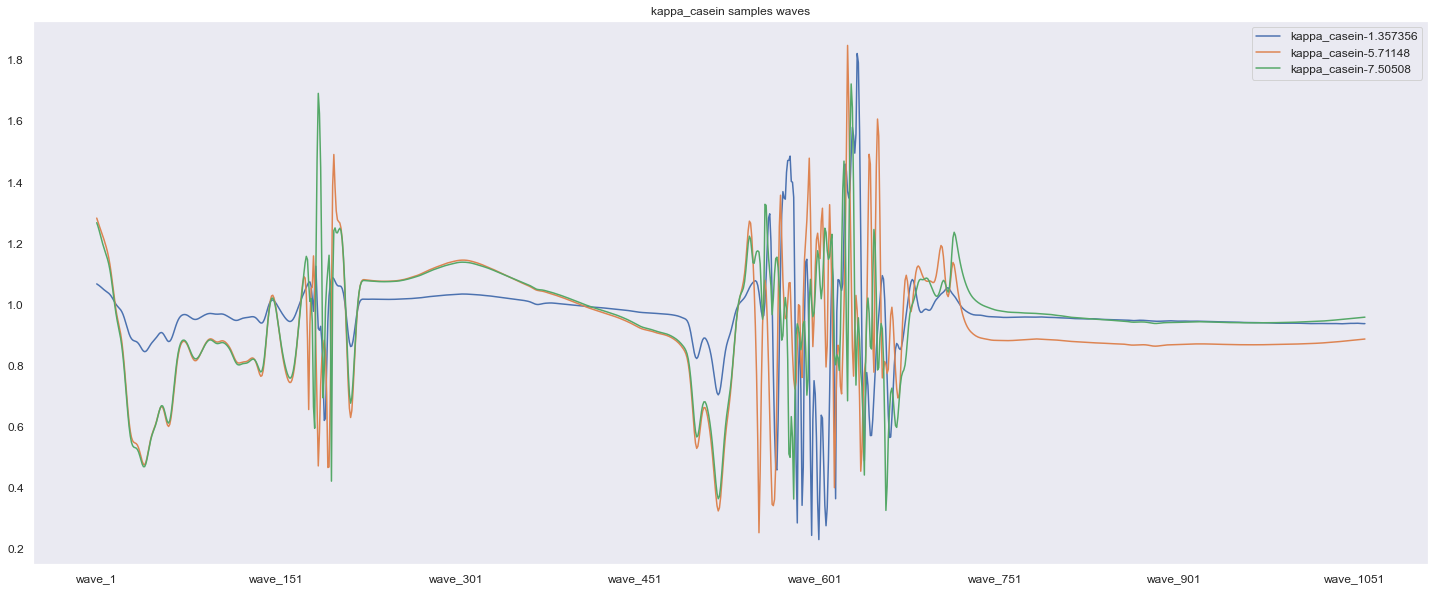

In [46]:
def plotWavesTarget(df, features, target='kappa_casein'):
    
    plt.figure(figsize=(25, 10))
    df_sorted = df.sort_values(target)
    #print(df_sorted.head())

    plt.plot(df_sorted[features].iloc[0, :].T, label=target + '-' + str(df_sorted[target].iloc[0]))
    #plt.plot(df_sorted[features].iloc[100, :].T, label=target + '-' + str(df_sorted[target].iloc[100]))
    plt.plot(df_sorted[features].iloc[201, :].T, label=target + '-' + str(df_sorted[target].iloc[201]))
    #plt.plot(df_sorted[features].iloc[300, :].T, label=target + '-' + str(df_sorted[target].iloc[300]))
    plt.plot(df_sorted[features].iloc[350, :].T, label=target + '-' + str(df_sorted[target].iloc[350]))

    #plt.xticks(rotation=45, ha='right')
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.title(target + ' samples waves')
    plt.legend()
    plt.grid()
    plt.savefig('imgout/samples-' + target + '.png')
    plt.show()
    

if __name__ == "__main__":
    plotWavesTarget(df = training_kappa, features = features, target = 'kappa_casein')

In [23]:
training_kappa.head()

,kappa_casein,Casein_micelle_size,Native_pH,wave_1,wave_2,wave_3,wave_4,wave_5,wave_6,wave_7,...,wave_1051,wave_1052,wave_1053,wave_1054,wave_1055,wave_1056,wave_1057,wave_1058,wave_1059,wave_1060
85,4.75186,142.2,6.75,1.128620,1.121789,1.115452,1.109376,1.103542,1.097927,1.092496,...,0.979171,0.979293,0.979416,0.979531,0.979629,0.979723,0.979847,0.980001,0.980273,0.980636
132,5.21290,139.9,6.54,1.242369,1.230312,1.219599,1.209504,1.199764,1.190190,1.180635,...,0.928095,0.928308,0.928583,0.928907,0.929243,0.929561,0.929861,0.930134,0.930507,0.930986
96,4.82548,177.3,6.73,1.215612,1.202723,1.192170,1.183414,1.175755,1.168402,1.160718,...,0.928064,0.928320,0.928672,0.929130,0.929671,0.930254,0.930828,0.931281,0.931705,0.931977
107,4.97430,245.0,6.74,1.247137,1.235025,1.224431,1.214466,1.204637,1.194742,1.184815,...,0.926982,0.927421,0.928042,0.928700,0.929215,0.929448,0.929371,0.929131,0.928823,0.928680
140,5.30620,158.7,NaN,1.178803,1.170875,1.162666,1.154521,1.146977,1.140336,1.134607,...,0.923169,0.923539,0.923917,0.924294,0.924659,0.925001,0.925312,0.925538,0.925798,0.926051


In [24]:
training_kappa.describe().T

,count,mean,std,min,25%,50%,75%,max
kappa_casein,399.0,5.923762,1.829605,1.357356,4.855130,5.708300,6.775000,22.233240
Casein_micelle_size,387.0,237.249793,352.639491,63.370000,154.400000,168.700000,190.750000,3640.000000
Native_pH,394.0,6.655206,0.112535,5.860000,6.595250,6.650000,6.720000,7.060000
wave_1,399.0,1.240081,0.060033,1.066316,1.203380,1.237532,1.275744,1.450830
wave_2,399.0,1.227432,0.056815,1.063704,1.192614,1.224089,1.259619,1.430645
...,...,...,...,...,...,...,...,...
wave_1056,399.0,0.917545,0.039383,0.720870,0.902545,0.925514,0.941070,0.993833
wave_1057,399.0,0.917917,0.039384,0.720985,0.902965,0.925703,0.941482,0.994057
wave_1058,399.0,0.918233,0.039383,0.721234,0.903294,0.925847,0.941842,0.994278
wave_1059,399.0,0.918612,0.039376,0.721709,0.903678,0.926413,0.942313,0.994554


In [25]:
training_kappa['kappa_casein'].mean()

5.923761749373433

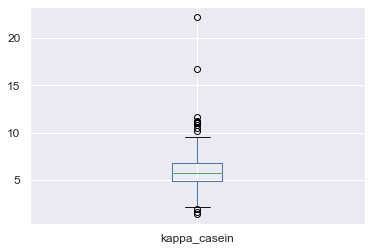

In [26]:
training_kappa['kappa_casein'].plot(kind='box')

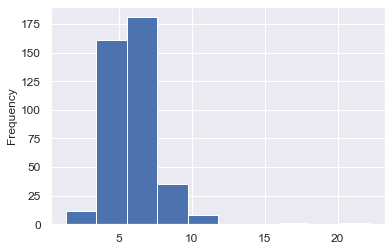

In [27]:
training_kappa['kappa_casein'].plot(kind='hist')

In [28]:
training_kappa['kappa_casein'].mean() + 3 * training_kappa['kappa_casein'].std()

11.412576524012291

In [29]:
#training_kappa = training_kappa[training_kappa['kappa_casein'] <= training_kappa['kappa_casein'].quantile(q=0.99)]
training_kappa = training_kappa[training_kappa['kappa_casein'] <= training_kappa['kappa_casein'].mean() + 3 * training_kappa['kappa_casein'].std()]

In [30]:
training_kappa.describe().T

,count,mean,std,min,25%,50%,75%,max
kappa_casein,396.0,5.840767,1.520902,1.357356,4.844377,5.703570,6.759465,11.225500
Casein_micelle_size,384.0,237.927266,353.933679,63.370000,154.750000,169.000000,191.325000,3640.000000
Native_pH,392.0,6.654967,0.112773,5.860000,6.594750,6.650000,6.720000,7.060000
wave_1,396.0,1.239808,0.060173,1.066316,1.202948,1.237202,1.275583,1.450830
wave_2,396.0,1.227180,0.056953,1.063704,1.192488,1.222853,1.259418,1.430645
...,...,...,...,...,...,...,...,...
wave_1056,396.0,0.917239,0.039373,0.720870,0.902439,0.925053,0.940952,0.993833
wave_1057,396.0,0.917610,0.039374,0.720985,0.902880,0.925476,0.941363,0.994057
wave_1058,396.0,0.917926,0.039371,0.721234,0.903174,0.925824,0.941581,0.994278
wave_1059,396.0,0.918305,0.039365,0.721709,0.903539,0.926245,0.941962,0.994554


In [31]:
X_kappa = training_kappa[features]
y_kappa = training_kappa['kappa_casein']
linreg = LinearRegression().fit(X_kappa[features], y_kappa)

# Print the estimated linear regression coefficients.
#print("Features: \n", features)
#print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", linreg.intercept_)
print("\nFeatures and coeficients:", list(zip(features, linreg.coef_))[:10])


Intercept: 
 12621340.425421173

Features and coeficients: [('wave_1', 125823594.84796157), ('wave_2', -178234446.62596017), ('wave_3', 53993767.80481843), ('wave_4', -291315371.22243476), ('wave_5', 199485395.37870827), ('wave_6', 674107711.6677057), ('wave_7', -257283082.2669634), ('wave_8', -777143057.6106224), ('wave_9', -266790513.5144677), ('wave_10', 843184690.9959491)]


In [32]:
# Predicted scores for each example. 
linreg_predictions = linreg.predict(X_kappa[features])

actual_vs_predicted = pd.concat([y_kappa, pd.DataFrame(linreg_predictions, columns=['Predicted'], index=y_kappa.index)], axis=1)
actual_vs_predicted.sort_values('kappa_casein').head(10)

,kappa_casein,Predicted
0,1.357356,1.357377
1,1.642316,1.642343
2,1.937150,1.937177
552,2.117274,2.117299
3,2.552068,2.552118
4,2.713626,2.713625
5,2.748992,2.749044
6,2.872650,2.872705
7,2.918938,2.918981
8,3.178458,3.178474


In [33]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    #print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))    

In [34]:
printMetrics(y_kappa, linreg_predictions)


RMSE:  0.21145074164729713
R2:  0.9806217599316346


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_kappa, y_kappa, test_size=0.25, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (297, 1060) (297,)
Test data shape:  (99, 1060) (99,)


In [36]:
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)
# Print the weights learned for each feature.
print("\nIntercept: \n", linreg.intercept_)
print("\nFeatures and coeficients:", list(zip(features, linreg.coef_))[:10])


Intercept: 
 1046857787.0709568

Features and coeficients: [('wave_1', 85520529.99498382), ('wave_2', -656881835.2673748), ('wave_3', 769916750.5369772), ('wave_4', 335347687.57886225), ('wave_5', -677315314.1763229), ('wave_6', -532461312.7068971), ('wave_7', 965893178.2829714), ('wave_8', 162459185.13711575), ('wave_9', -573603389.5979822), ('wave_10', -189118404.4077476)]


In [37]:
# Predicted price on training set
train_predictions = linreg.predict(X_train)
#print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, train_predictions)


RMSE:  0.20440738109053702
R2:  0.9829180053673585


In [38]:
# Predicted price on test set
test_predictions = linreg.predict(X_test)
printMetrics(y_test, test_predictions)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head().sort_values('kappa_casein'))


RMSE:  4316515.577410911
R2:  -9925601115669.58
Actual vs predicted on test:
      kappa_casein     Predicted
80        4.72486 -4.709496e+06
130       5.20298  2.497120e+06
187       5.63040  3.057529e+06
303       6.85258  2.009197e+06
551       6.95340 -1.071119e+06


In [39]:
error_measures = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
scores = cross_validate(RidgeCV(), X_kappa, y_kappa, scoring=error_measures, cv=4)
scores

{'fit_time': array([0.04880309, 0.02629089, 0.02590394, 0.027982  ]),
 'score_time': array([0.01377797, 0.01007414, 0.01028204, 0.01118398]),
 'test_neg_mean_absolute_error': array([-1.0074504 , -1.06668445, -0.94145406, -0.93308103]),
 'test_neg_mean_squared_error': array([-1.73328096, -1.95598747, -1.4192313 , -1.50390717]),
 'test_r2': array([0.31001047, 0.11719915, 0.32500251, 0.36636348])}

In [40]:
def printMetricsCV(regression_algo, X, y, metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']):
    #run cross-validation to compute the rmse for different folds, using different regression algorithms
    print('\n==============================================================================')
    scores = cross_validate(regression_algo, X, y, scoring=metrics, cv=4)
    scores
    #print("MAE: ", -scores['test_neg_mean_absolute_error'])
    print("RMSE: ", np.sqrt(-scores['test_neg_mean_squared_error']))
    print("R2: ", scores['test_r2'])

In [47]:
def algoCV(target, X, y, folds=4, error_measures = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']):
    
    algos_df = pd.DataFrame({"algo":[], "rmsecv": []})

    for algo in [LinearRegression(), PLSRegression(), Ridge(), RidgeCV(), RidgeCV(normalize=True), RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True), Lasso(), Lasso(normalize=True), ElasticNet(), RandomForestRegressor(n_estimators=100), GradientBoostingRegressor(n_estimators=100), KNeighborsRegressor(n_neighbors=1), MLPRegressor(), SVR(kernel='linear'), SVR(kernel='rbf')]:
        print(algo)
        scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
        #scores
        rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
        r2 = scores['test_r2']
        algos_df = algos_df.append({"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
             
        print("RMSE: ", rmse)
        print("R2: ", r2)
        print("RMSECV: ", np.mean(rmse))
        print("RMSECV std: ", np.std(rmse))
        print("R2CV: ", np.mean(r2))
        print("\n")
    
    print(algos_df.sort_values('rmsecv'))
    algos_df.sort_values('rmsecv').to_csv(target + "-rmsecv.csv")
    
if __name__ == "__main__":
    
    algoCV(target='kappa_casein', X = X_kappa, y = y_kappa, folds=4)
    

LinearRegression()
RMSE:  [  446878.34479832  6670856.65691098 25655249.54860693  4118070.13671187]
R2:  [-7.94972588e+10 -2.00844477e+13 -3.13041172e+14 -7.14507261e+12]
RMSECV:  9222763.671757026
RMSECV std:  9741828.381571308
R2CV:  -85087547335241.84


PLSRegression()
RMSE:  [1.24214191 1.27631432 1.2081736  1.24405666]
R2:  [0.3857913  0.26478906 0.30576316 0.34792209]
RMSECV:  1.2426716248419527
RMSECV std:  0.02410468686341535
R2CV:  0.3260663989157857


Ridge()
RMSE:  [1.344006   1.39722832 1.18141937 1.2417462 ]
R2:  [0.28092208 0.11888735 0.33616958 0.35034192]
RMSECV:  1.2910999738569893
RMSECV std:  0.08445102716761413
R2CV:  0.2715802326328567


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
RMSE:  [1.31654129 1.39856622 1.19131495 1.22633893]
R2:  [0.31001047 0.11719915 0.32500251 0.36636348]
RMSECV:  1.2831903457291851
RMSECV std:  0.08077290651984867
R2CV:  0.27964390317825705


RidgeCV(alphas=array([ 0.1,  1. , 10. ]), normalize=True)
RMSE:  [1.18001638 1.25921924 1.1152979

/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE:  [1.36625902 1.55422946 1.29808444 1.34021184]
R2:  [ 0.25691307 -0.09025215  0.1985898   0.24322623]
RMSECV:  1.3896961929966967
RMSECV std:  0.09805854392258286
R2CV:  0.15211923933446142


SVR(kernel='linear')
RMSE:  [1.43331704 1.43198827 1.20999617 1.25110081]
R2:  [0.18217937 0.07450176 0.30366702 0.34051674]
RMSECV:  1.3316005724245121
RMSECV std:  0.10209281854696384
R2CV:  0.22521622089027415


SVR()
RMSE:  [1.41947014 1.42154199 1.30340402 1.3217363 ]
R2:  [0.19790455 0.08795543 0.19200795 0.26394748]
RMSECV:  1.36653811265999
RMSECV std:  0.054360696141582364
R2CV:  0.1854538518687485


                                                 algo        rmsecv
5   RidgeCV(alphas=array([1.00000000e-02, 2.782559...  1.169727e+00
4   RidgeCV(alphas=array([ 0.1,  1. , 10. ]), norm...  1.174691e+00
9                             RandomForestRegressor()  1.180053e+00
10                        GradientBoostingRegressor()  1.192038e+00
1                                     PLSRegressi

In [48]:
#for algo in [PLSRegression(n_components=2), PLSRegression(n_components=4), PLSRegression(n_components=16), PLSRegression(n_components=32), PLSRegression(n_components=64)]:
algos_df = pd.DataFrame({"algo":[], "rmsecv": []})
for i in np.arange(1, 20):
    algo = PLSRegression(n_components=i)
    print(algo)
    scores = cross_validate(algo, X_kappa, y_kappa, scoring=error_measures, cv=4)
    #scores
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2 = scores['test_r2']
    
    print("RMSE: ", rmse)
    print("R2: ", r2)
    print("RMSECV: ", np.mean(rmse))
    print("RMSECV std: ", np.std(rmse))
    print("R2CV: ", np.mean(r2))
    print("\n")
    algos_df = algos_df.append({"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
       
print(algos_df.sort_values('rmsecv')) 

PLSRegression(n_components=1)
RMSE:  [1.27620481 1.36474326 1.33625788 1.3235209 ]
R2:  [0.35164287 0.15938217 0.15076178 0.26195851]
RMSECV:  1.3251817146027898
RMSECV std:  0.0319737893333308
R2CV:  0.23093633343240194


PLSRegression()
RMSE:  [1.24214191 1.27631432 1.2081736  1.24405666]
R2:  [0.3857913  0.26478906 0.30576316 0.34792209]
RMSECV:  1.2426716248419527
RMSECV std:  0.02410468686341535
R2CV:  0.3260663989157857


PLSRegression(n_components=3)
RMSE:  [1.24708779 1.27858375 1.06218079 1.16926278]
R2:  [0.38089033 0.26217216 0.46340594 0.42397224]
RMSECV:  1.189278775726858
RMSECV std:  0.08347424529848964
R2CV:  0.38261016776533036


PLSRegression(n_components=4)
RMSE:  [1.18501478 1.27827234 1.07296045 1.10402553]
R2:  [0.44098808 0.26253153 0.4524593  0.48645631]
RMSECV:  1.160068275154947
RMSECV std:  0.07956615304131444
R2CV:  0.41060880452499815


PLSRegression(n_components=5)
RMSE:  [1.25710929 1.29280922 1.09358098 1.18534869]
R2:  [0.37090011 0.24566275 0.43121142 

In [38]:
#for algo in [GradientBoostingRegressor(n_estimators=10), GradientBoostingRegressor(n_estimators=50), GradientBoostingRegressor(n_estimators=100), GradientBoostingRegressor(n_estimators=150), GradientBoostingRegressor(n_estimators=200),GradientBoostingRegressor(n_estimators=500)]:
#    print(algo)
#    scores = cross_validate(algo, X_kappa, y_kappa, scoring=error_measures, cv=4)
#    #scores
#    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
#    print("RMSE: ", rmse)
#    print("RMSECV: ", np.mean(rmse))
#    print("RMSECV std: ", np.std(rmse), "\n")
        

In [39]:
'''
for algo in [RandomForestRegressor(n_estimators=10), RandomForestRegressor(n_estimators=50), RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=150), RandomForestRegressor(n_estimators=200), RandomForestRegressor(n_estimators=500)]:
    print(algo)
    scores = cross_validate(algo, X, y, scoring=error_measures, cv=4)
    #scores
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    print("RMSE: ", rmse)
    print("RMSECV: ", np.mean(rmse))
    print("RMSECV std: ", np.std(rmse), "\n")
'''

'\nfor algo in [RandomForestRegressor(n_estimators=10), RandomForestRegressor(n_estimators=50), RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=150), RandomForestRegressor(n_estimators=200), RandomForestRegressor(n_estimators=500)]:\n    print(algo)\n    scores = cross_validate(algo, X, y, scoring=error_measures, cv=4)\n    #scores\n    rmse = np.sqrt(-scores[\'test_neg_mean_squared_error\'])\n    print("RMSE: ", rmse)\n    print("RMSECV: ", np.mean(rmse))\n    print("RMSECV std: ", np.std(rmse), "\n")\n'

In [40]:
#for algo in [RandomForestRegressor(n_estimators=10), RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=500)]:
#    print(algo)
#    scores = cross_validate(algo, X, y, scoring=metrics, cv=5)
    #scores
#    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
#    print("RMSE: ", rmse)
#    print("RMSECV: ", np.mean(rmse), "\n")

In [41]:
'''
for algo in [GradientBoostingRegressor(loss='huber', n_estimators=50), GradientBoostingRegressor(loss='huber', n_estimators=100), GradientBoostingRegressor(loss='huber',n_estimators=150), GradientBoostingRegressor(loss='huber',n_estimators=200)]:
    print(algo)
    scores = cross_validate(algo, X, y, scoring=error_measures, cv=5)
    #scores
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    print("RMSE: ", rmse)
    print("RMSECV: ", np.mean(rmse))
    print("RMSECV std: ", np.std(rmse), "\n")
'''

'\nfor algo in [GradientBoostingRegressor(loss=\'huber\', n_estimators=50), GradientBoostingRegressor(loss=\'huber\', n_estimators=100), GradientBoostingRegressor(loss=\'huber\',n_estimators=150), GradientBoostingRegressor(loss=\'huber\',n_estimators=200)]:\n    print(algo)\n    scores = cross_validate(algo, X, y, scoring=error_measures, cv=5)\n    #scores\n    rmse = np.sqrt(-scores[\'test_neg_mean_squared_error\'])\n    print("RMSE: ", rmse)\n    print("RMSECV: ", np.mean(rmse))\n    print("RMSECV std: ", np.std(rmse), "\n")\n'

# Findings so far

After removing outliers: 
+ RidgeCV with normalize=True and RandomForest seem to work well wrt RMSECV. 
+ RandomForestRegressor and GradientBoostingRegressor work ok, but not better than linear models.
+ Lets look at single train_test split to see what the models learn.


In [41]:
lasso = Lasso(normalize=True).fit(X_train, y_train)
# Print the weights learned for each feature.
print("Mean of training targets: \n", y_train.mean())

print("Lasso")
print("\nIntercept: \n", lasso.intercept_)
print("Features and coeficients:", list(zip(features, lasso.coef_))[:10])
#print("Sorted coefs: \n", sorted(lasso.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = lasso.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':lasso.coef_})
feature_importance.sort_values('importance', ascending=False)

Mean of training targets: 
 5.806567367003367
Lasso

Intercept: 
 5.806567367003367
Features and coeficients: [('wave_1', 0.0), ('wave_2', 0.0), ('wave_3', 0.0), ('wave_4', 0.0), ('wave_5', 0.0), ('wave_6', 0.0), ('wave_7', 0.0), ('wave_8', 0.0), ('wave_9', 0.0), ('wave_10', 0.0)]

RMSE:  1.3769208380984348
R2:  -0.00996921925915073

Actual vs predicted on test:
      kappa_casein  Predicted
80        4.72486   5.806567
187       5.63040   5.806567
130       5.20298   5.806567
551       6.95340   5.806567
303       6.85258   5.806567


,feature,importance
0,wave_1,0.0
712,wave_713,-0.0
698,wave_699,0.0
699,wave_700,0.0
700,wave_701,0.0
...,...,...
358,wave_359,0.0
359,wave_360,0.0
360,wave_361,0.0
361,wave_362,0.0


In [42]:
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_train, y_train)
#ridgecv = RidgeCV(normalize=True).fit(X_train, y_train)

# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = ridgecv.predict(X_test)
printMetrics(y_test, test_predictions)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('kappa_casein'))

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
feature_importance.sort_values('importance', ascending=False)

RidgeCV

Intercept: 
 -25.617129211661812
Features and coeficients: [('wave_1', 0.030398583536926517), ('wave_2', 0.01854724561210928), ('wave_3', 0.014579880604576394), ('wave_4', 0.018766941960412408), ('wave_5', 0.029632394520019284), ('wave_6', 0.04400421505585722), ('wave_7', 0.058311781236069476), ('wave_8', 0.0696221383072612), ('wave_9', 0.07625557195164415), ('wave_10', 0.07814692498056743)]

RMSE:  1.0739677721640761
R2:  0.3855696052527643
Actual vs predicted on test:
      kappa_casein  Predicted
3        2.552068   4.821934
18       3.596480   4.859027
19       3.621304   3.866293
20       3.621884   3.574127
24       3.710616   5.304737
25       3.720848   4.805969
30       3.787046   4.737604
36       3.882592   4.420701
37       3.997100   5.337741
40       4.015828   5.320222
41       4.016200   5.234951
47       4.223620   4.819108
50       4.313220   5.232933
64       4.530980   5.105693
67       4.542440   5.163615
69       4.561240   5.305284
71       4.598760   4.

,feature,importance
219,wave_220,1.222177
407,wave_408,0.595646
408,wave_409,0.590471
406,wave_407,0.582498
409,wave_410,0.567306
...,...,...
90,wave_91,-0.795127
91,wave_92,-0.809921
94,wave_95,-0.812582
92,wave_93,-0.823217


In [41]:
randomforest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = randomforest.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('kappa_casein'))

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

RandomForestRegressor

RMSE:  1.0646122494873573
R2:  0.39622780252072864

Actual vs predicted on test:
      kappa_casein  Predicted
3        2.552068   4.490409
18       3.596480   4.564349
19       3.621304   4.078526
20       3.621884   3.329886
24       3.710616   4.591176
25       3.720848   4.420507
30       3.787046   4.429173
36       3.882592   4.106139
37       3.997100   5.393859
40       4.015828   5.542806
41       4.016200   4.720019
47       4.223620   4.505921
50       4.313220   5.401173
64       4.530980   5.307593
67       4.542440   5.249553
69       4.561240   5.281335
71       4.598760   5.051617
80       4.724860   5.759708
88       4.769800   4.334288
89       4.777560   6.402804
90       4.781380   5.238490
92       4.804440   5.185228
93       4.808052   4.728150
111      5.038360   5.165802
113      5.051920   4.656465
121      5.144380   5.616293
122      5.144520   5.127091
126      5.167980   5.182523
128      5.174980   5.322759
130      5.202980   4.287

,feature,importance
140,wave_141,5.852006e-02
141,wave_142,5.371827e-02
139,wave_140,4.046174e-02
136,wave_137,2.959255e-02
86,wave_87,2.008430e-02
...,...,...
996,wave_997,5.818628e-07
866,wave_867,5.399826e-07
942,wave_943,5.218946e-07
838,wave_839,3.762848e-07


In [42]:
'''
MLPRegressor
nnr = MLPRegressor().fit(X_train, y_train)
# Print the weights learned for each feature.
print("MLPRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = nnr.predict(X_test)
printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1))
'''

'\nMLPRegressor\nnnr = MLPRegressor().fit(X_train, y_train)\n# Print the weights learned for each feature.\nprint("MLPRegressor")\n#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])\n#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])\n\n# Predicted price on test set\ntest_predictions = nnr.predict(X_test)\nprintMetrics(y_test, test_predictions)\n#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=[\'Predicted\'], index=y_test.index)], axis=1))\n'

In [43]:
'''
SVR
svr = SVR(kernel='linear').fit(X_train, y_train)
# Print the weights learned for each feature.
print("SupportVectorRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = svr.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())
'''

'\nSVR\nsvr = SVR(kernel=\'linear\').fit(X_train, y_train)\n# Print the weights learned for each feature.\nprint("SupportVectorRegressor")\n#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])\n#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])\n\n# Predicted price on test set\ntest_predictions = svr.predict(X_test)\nprintMetrics(y_test, test_predictions)\nprint("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=[\'Predicted\'], index=y_test.index)], axis=1).head())\n'

# Findings so far for time series as tabular data: target 'kappa_casein'

+ tested algorithms on time series as tabular data: linear models, ensembles, knn, neural networks
+ conclusions based on cross validation and a single train/test split
+ Lasso does not learn anything, it always predicts the intercept (the avg of training targets), all other coeficients are zero
+ RidgeCV works pretty well, seems to be learning something, best in linear models, normalize=true helps here
+ RandomForestRegressor and GradientBoostedRegressor work best in ensembles; GBR seems to somewhat agree with RandomForestRegressor wrt feature importance
+ KNN and NeuralNet does not seem to work well (but no tuning)
+ feature importances from RidgeCV and GradientBoostedRegressor models do not agree

# Test some improvements of the best models on a single train/test split: RidgeCV, GBR, SVR.

In [44]:
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = ridgecv.predict(X_test)
printMetrics(y_test, test_predictions)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('kappa_casein'))

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
feature_importance.sort_values('importance', ascending=False)


RidgeCV

Intercept: 
 -25.617129211661812
Features and coeficients: [('wave_1', 0.030398583536926517), ('wave_2', 0.01854724561210928), ('wave_3', 0.014579880604576394), ('wave_4', 0.018766941960412408), ('wave_5', 0.029632394520019284), ('wave_6', 0.04400421505585722), ('wave_7', 0.058311781236069476), ('wave_8', 0.0696221383072612), ('wave_9', 0.07625557195164415), ('wave_10', 0.07814692498056743)]

RMSE:  1.0739677721640761
R2:  0.3855696052527643
Actual vs predicted on test:
      kappa_casein  Predicted
3        2.552068   4.821934
18       3.596480   4.859027
19       3.621304   3.866293
20       3.621884   3.574127
24       3.710616   5.304737
25       3.720848   4.805969
30       3.787046   4.737604
36       3.882592   4.420701
37       3.997100   5.337741
40       4.015828   5.320222
41       4.016200   5.234951
47       4.223620   4.819108
50       4.313220   5.232933
64       4.530980   5.105693
67       4.542440   5.163615
69       4.561240   5.305284
71       4.598760   4.

,feature,importance
219,wave_220,1.222177
407,wave_408,0.595646
408,wave_409,0.590471
406,wave_407,0.582498
409,wave_410,0.567306
...,...,...
90,wave_91,-0.795127
91,wave_92,-0.809921
94,wave_95,-0.812582
92,wave_93,-0.823217


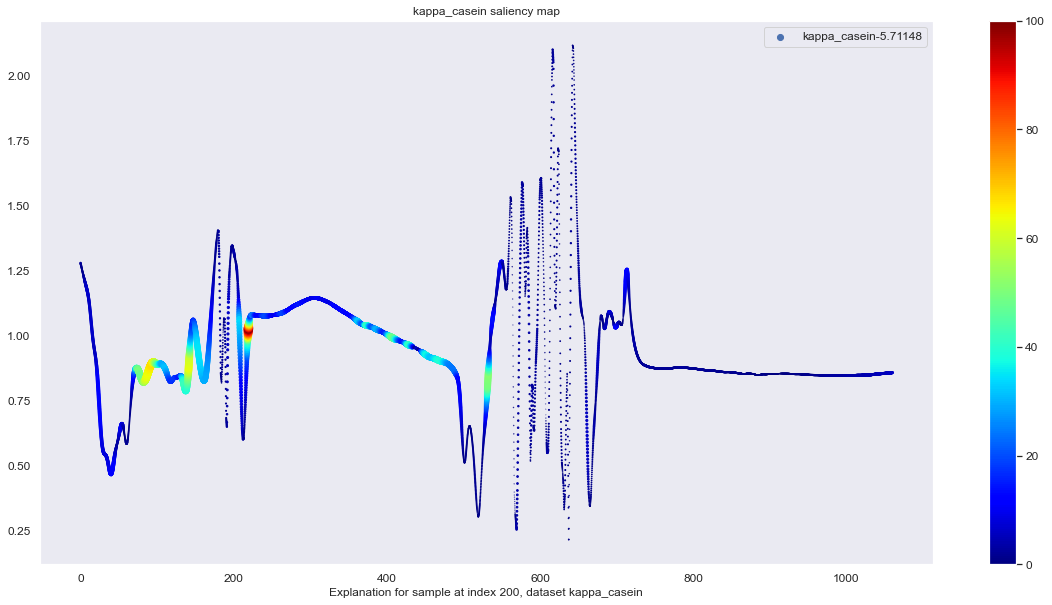

In [45]:

def saliency_map(X, y, example_idx, explanation_weights, target = 'kappa_casein'):
    idx = example_idx
    #test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
    #test_data = np.genfromtxt(test_file, delimiter=',')
    #test_x, test_y  = test_data[:,1:], test_data[:,0]
    #test_y = y
    #le = preprocessing.LabelEncoder()
    #le.fit(test_y)
    #transformed_test_y = le.transform(test_y)
    #n_class = np.unique(transformed_test_y).shape[0]
    
    def transform(X):
        ma, mi = np.max(X), np.min(X)
        X = (X - mi)/(ma - mi)
        return X*100
    
    weight = abs(explanation_weights)
    weight = transform(weight)
    ts = X.iloc[idx, :]
    
    
    max_length1, max_length2 = len(ts),10000 #
    x1 = np.linspace(0,max_length1,num = max_length1)
    x2 = np.linspace(0,max_length1,num = max_length2)
    y1 = ts
    
    f = interp1d(x1, y1) # interpolate time series
    fcas = interp1d(x1, weight) # interpolate weight color
    weight = fcas(x2) # convert vector of original weight vector to new weight vector

    plt.figure(figsize=(20, 10))
    plt.scatter(x2,f(x2), c = weight, cmap = 'jet', marker='.', s = 3*weight, vmin = 0,vmax = 100, label=target + '-' + str(y[idx]))
    plt.xlabel('Explanation for sample at index %d, dataset %s' %(example_idx, target))
    plt.title(target + ' saliency map')
    #plt.gca().twinx().plot(weight, color = 'r', label = 'SaliencyScale')
    plt.legend()
    plt.grid()
    plt.colorbar()
    plt.savefig('imgout/samples-' + target + '-saliencymap-ridgecv.png')
    plt.show()
    #plt.savefig('imgout/samples-' + target + '-saliencymap-ridgecv.png')
    

if __name__ == "__main__":
    
    saliency_map(X = X_kappa, y = y_kappa, example_idx = 200, explanation_weights = feature_importance['importance'], target='kappa_casein')
    

In [49]:
print("RidgeCV")
test_predictions = ridgecv.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)

RidgeCV
Predictions on the unlabeled test data: 
 [5.65524719 2.10318175 1.59435127 2.58082531 5.74763489 4.12683939
 6.03854133 4.22442777 6.08552264 5.62074718 5.05651618 4.92307137
 4.71026047 5.90959887 4.18886337 5.0371014  6.23093356 6.09366241
 4.97975085 5.63547889 5.32568716 4.74291074 4.46665515 5.44346534
 4.9699309  5.93152636 4.92030986 5.45365544 6.00256138 7.24769052
 4.65381847 5.75855037 4.4846361  4.81015949 5.88900399 5.52762581
 5.01072859 7.15037628 6.27605296 6.16983609 5.63281374 5.49134987
 5.82651384 5.4423625  5.90126205 5.82142443 8.12137663 6.51811348
 6.34580842 6.42600293 7.12501774 7.36578842 7.30836009 6.68425709
 6.73958273 5.78641894 6.30627866 5.96284648 7.42916224 6.39751112
 6.99814311 7.96738988 6.66658825 6.26958188 8.03158998 7.23476998
 6.14982984 7.30477924 7.75774559]


In [50]:
#Retrain best model on full data
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_kappa, y_kappa)

# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-kappa_casein-featureimportance-ridgecv-no-outliers-alphas-normalizeTrue.csv', index=False)

# Predicted price on test set
test_predictions = ridgecv.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-kappa_cassein']), test_df], axis=1)
test_df_with_predictions.to_csv('23042021-kappa_casein-test-predictions-ridgecv-no-outliers-alphas-normalizeTrue.csv', index=False)

#training_df[features] 
training_predictions = ridgecv.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
pred_df = pd.concat([training_df['kappa_casein'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['kappa_casein'].index)], axis=1)
print("\nActual vs predicted on training_df:\n", pred_df.sort_values('kappa_casein', ascending=True))

#print(training_df['kappa_casein'])
#print(training_predictions)

RidgeCV

Intercept: 
 -27.921306068861433
Features and coeficients: [('wave_1', 0.0003361882223939226), ('wave_2', -0.0013605692264380452), ('wave_3', 0.004729701709471028), ('wave_4', 0.015996164615564145), ('wave_5', 0.029602948181220206), ('wave_6', 0.04271558507750681), ('wave_7', 0.053199555326642396), ('wave_8', 0.05986573270207466), ('wave_9', 0.062347089338750404), ('wave_10', 0.06099030763273814)]
      feature  importance
219  wave_220    1.302920
408  wave_409    0.683543
407  wave_408    0.679217
409  wave_410    0.666234
406  wave_407    0.654676
..        ...         ...
91    wave_92   -0.812544
92    wave_93   -0.821988
93    wave_94   -0.822016
142  wave_143   -0.838446
141  wave_142   -0.862785

[1060 rows x 2 columns]
Predictions on the unlabeled test data: 
 [5.68116944 2.08924907 1.78354384 2.76905107 5.75677506 4.13849879
 5.90332255 4.33960099 6.21384307 5.62872568 4.96709709 5.06636004
 4.83464296 5.85673107 4.28567327 5.10561639 6.16629183 6.12576681
 4.8499857

In [51]:
# Retrain on full train data and predict for full test set witrh best RidgeCV and GBR
randomforest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = randomforest.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1))

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

RandomForestRegressor

RMSE:  1.081313066063389
R2:  0.37713619479394145

Actual vs predicted on test:
      kappa_casein  Predicted
80       4.724860   5.710830
187      5.630400   6.249169
130      5.202980   4.202872
551      6.953400   6.161615
303      6.852580   6.902851
262      6.299920   5.319233
3        2.552068   4.627813
113      5.051920   4.869627
192      5.673220   6.081346
201      5.729220   5.733129
128      5.174980   5.362087
208      5.818700   6.952353
276      6.455360   5.363196
351      7.585000   5.800357
88       4.769800   4.370775
345      7.443820   6.363327
242      6.153540   6.505617
47       4.223620   4.483182
25       3.720848   4.407131
64       4.530980   5.156286
298      6.776920   6.369361
141      5.309260   4.191045
126      5.167980   5.102281
365      8.067040   6.489029
19       3.621304   4.047809
89       4.777560   6.174648
69       4.561240   5.006758
361      7.844640   6.166770
18       3.596480   4.766019
30       3.787046   4.3518

,feature,importance
140,wave_141,5.876936e-02
136,wave_137,4.808465e-02
141,wave_142,3.535123e-02
87,wave_88,2.810540e-02
137,wave_138,2.362823e-02
...,...,...
899,wave_900,3.241155e-07
851,wave_852,2.021700e-07
808,wave_809,8.842668e-08
898,wave_899,0.000000e+00


In [52]:
randomforest = RandomForestRegressor(n_estimators=100).fit(X_kappa, y_kappa)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
#test_predictions = gbr.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-kappa_casein-featureimportance-randomforest-n100-nooutliers.csv', index=False)

# Predicted price on test set
test_predictions = randomforest.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-kappa_cassein']), test_df], axis=1)

test_df_with_predictions.to_csv('23042021-kappa_casein-test-predictions-randomforest-n100-nooutliers.csv', index=False)

training_predictions = randomforest.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
pred_df = pd.concat([training_df['kappa_casein'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['kappa_casein'].index)], axis=1)
print("Actual vs predicted on training_df:\n", pred_df.sort_values('kappa_casein', ascending=True))

RandomForestRegressor
        feature    importance
141    wave_142  7.162809e-02
136    wave_137  4.450724e-02
140    wave_141  4.428713e-02
137    wave_138  4.193125e-02
161    wave_162  3.499634e-02
...         ...           ...
1053  wave_1054  1.180885e-06
995    wave_996  1.053876e-06
845    wave_846  1.019436e-06
887    wave_888  7.756394e-07
794    wave_795  3.997534e-07

[1060 rows x 2 columns]
Predictions on the unlabeled test data: 
 [5.76196704 2.16651658 2.04587926 2.75138038 6.06304766 4.36330696
 6.01117404 4.64979932 6.44792933 5.46096064 4.78847524 4.7314224
 4.42504816 5.52420464 4.7088142  5.18995606 5.75938305 6.10317434
 4.55001564 6.11084225 5.41041396 5.1620874  4.98030292 5.34190986
 5.67037786 6.0516279  5.00999922 5.55674178 5.65807618 7.23990182
 4.68196534 5.71175984 5.43421402 4.42785562 5.97611188 5.4764172
 5.43306898 7.36703521 6.60324886 6.09486266 5.6992837  5.17356172
 5.74187894 6.26060988 6.1357214  6.1198209  7.50932373 6.75237448
 6.45076214 6.510

In [60]:
'''
gbr = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("GradientBoostingRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = gbr.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':gbr.feature_importances_})
feature_importance.sort_values('importance', ascending=False)
'''

'\ngbr = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)\n# Print the weights learned for each feature.\nprint("GradientBoostingRegressor")\n#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])\n#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])\n\n# Predicted price on test set\ntest_predictions = gbr.predict(X_test)\nprintMetrics(y_test, test_predictions)\nprint("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=[\'Predicted\'], index=y_test.index)], axis=1).head())\n\nfeature_importance = pd.DataFrame({\'feature\': features, \'importance\':gbr.feature_importances_})\nfeature_importance.sort_values(\'importance\', ascending=False)\n'

In [61]:
'''
gbr = GradientBoostingRegressor(n_estimators=100).fit(X_kappa, y_kappa)
# Print the weights learned for each feature.
print("GradientBoostingRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
#test_predictions = gbr.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':gbr.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))

# Predicted price on test set
test_predictions = gbr.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-kappa_cassein']), test_df], axis=1)

test_df_with_predictions.to_csv('17042021-kappa_casein-test-predictions-gbr-loss-ls-n100-nooutliers-perc99.csv', index=False)

training_predictions = gbr.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
print("Actual vs predicted on test:\n", pd.concat([training_df['kappa_casein'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['kappa_casein'].index)], axis=1).head(600))
print("GradientBoostedRegressor")
test_predictions = gbr.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
'''

'\ngbr = GradientBoostingRegressor(n_estimators=100).fit(X_kappa, y_kappa)\n# Print the weights learned for each feature.\nprint("GradientBoostingRegressor")\n#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])\n#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])\n\n# Predicted price on test set\n#test_predictions = gbr.predict(X_test)\n#printMetrics(y_test, test_predictions)\n#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=[\'Predicted\'], index=y_test.index)], axis=1).head())\n\nfeature_importance = pd.DataFrame({\'feature\': features, \'importance\':gbr.feature_importances_})\nprint(feature_importance.sort_values(\'importance\', ascending=False))\n\n# Predicted price on test set\ntest_predictions = gbr.predict(test_df)\nprint("Predictions on the unlabeled test data: \n", test_predictions)\ntest_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=[\'predicted-kappa_cass

# Findings so far:
+ Lets look at the other 2 targets. 
+ We first do CV, then single split.

# Target: micelle

In [49]:
training_df.describe().T

,count,mean,std,min,25%,50%,75%,max
kappa_casein,399.0,5.923762,1.829605,1.357356,4.855130,5.708300,6.775000,22.233240
Casein_micelle_size,538.0,229.991245,343.098368,63.120000,156.525000,172.450000,193.800000,4063.000000
Native_pH,548.0,6.682051,0.121584,5.860000,6.610000,6.680000,6.754250,7.060000
wave_1,553.0,1.232795,0.055922,1.066316,1.193258,1.227763,1.266825,1.450830
wave_2,553.0,1.220577,0.052950,1.063704,1.184667,1.216669,1.251859,1.430645
...,...,...,...,...,...,...,...,...
wave_1056,553.0,0.916205,0.044334,0.718883,0.904185,0.927922,0.942278,0.993833
wave_1057,553.0,0.916567,0.044336,0.718912,0.904682,0.928055,0.942768,0.994057
wave_1058,553.0,0.916869,0.044339,0.719014,0.905155,0.928098,0.942998,0.994278
wave_1059,553.0,0.917231,0.044341,0.719333,0.905517,0.928465,0.943080,0.994554


In [50]:
training_casein = training_df[training_df["Casein_micelle_size"].isnull() == False]
training_casein.describe().T

,count,mean,std,min,25%,50%,75%,max
kappa_casein,387.0,5.944055,1.847076,1.357356,4.861060,5.733260,6.798500,22.233240
Casein_micelle_size,538.0,229.991245,343.098368,63.120000,156.525000,172.450000,193.800000,4063.000000
Native_pH,533.0,6.678053,0.120286,5.860000,6.610000,6.680000,6.750000,7.060000
wave_1,538.0,1.234499,0.055540,1.066316,1.195047,1.230804,1.268923,1.450830
wave_2,538.0,1.222175,0.052596,1.063704,1.186033,1.218286,1.253952,1.430645
...,...,...,...,...,...,...,...,...
wave_1056,538.0,0.915508,0.044589,0.718883,0.903222,0.927253,0.942052,0.993833
wave_1057,538.0,0.915873,0.044592,0.718912,0.903455,0.927613,0.942382,0.994057
wave_1058,538.0,0.916179,0.044597,0.719014,0.903646,0.927622,0.942684,0.994278
wave_1059,538.0,0.916544,0.044600,0.719333,0.903927,0.927983,0.942943,0.994554


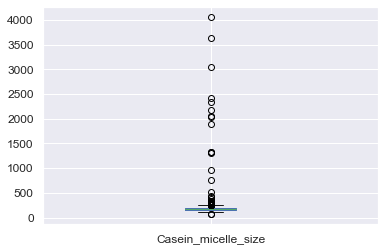

In [51]:
training_casein['Casein_micelle_size'].plot(kind='box')

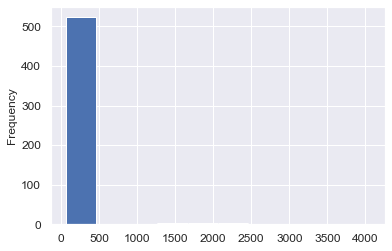

In [52]:
training_casein['Casein_micelle_size'].plot(kind='hist')

In [53]:
training_casein.sort_values(by='Casein_micelle_size')

,kappa_casein,Casein_micelle_size,Native_pH,wave_1,wave_2,wave_3,wave_4,wave_5,wave_6,wave_7,...,wave_1051,wave_1052,wave_1053,wave_1054,wave_1055,wave_1056,wave_1057,wave_1058,wave_1059,wave_1060
396,NaN,63.12,6.610,1.257494,1.245571,1.233886,1.222204,1.210651,1.199322,1.188286,...,0.908636,0.909167,0.909749,0.910303,0.910767,0.911124,0.911405,0.911634,0.911938,0.912313
188,5.639080,63.37,6.633,1.223653,1.213885,1.204399,1.195115,1.185949,1.176670,1.167102,...,0.927876,0.928230,0.928611,0.929025,0.929470,0.929923,0.930359,0.930697,0.931046,0.931354
397,NaN,109.10,6.581,1.268738,1.251631,1.234899,1.219350,1.205685,1.193872,1.183392,...,0.951399,0.951779,0.952151,0.952517,0.952879,0.953243,0.953611,0.953932,0.954316,0.954703
24,3.710616,110.70,6.650,1.237532,1.225069,1.214012,1.203726,1.193845,1.184187,1.174718,...,0.939687,0.939892,0.940098,0.940332,0.940632,0.941025,0.941500,0.941938,0.942401,0.942758
185,5.613480,116.40,6.539,1.211637,1.197455,1.182818,1.168124,1.154143,1.141503,1.130673,...,0.954773,0.955063,0.955357,0.955665,0.955990,0.956331,0.956685,0.956972,0.957331,0.957680
398,NaN,121.20,6.567,1.222722,1.211742,1.201357,1.191525,1.182424,1.173964,1.165860,...,0.958330,0.958769,0.959245,0.959734,0.960210,0.960648,0.961033,0.961322,0.961624,0.961917
322,7.055400,125.00,6.634,1.188882,1.179970,1.169348,1.158528,1.148839,1.141025,1.135181,...,0.924675,0.925045,0.925450,0.925875,0.926302,0.926706,0.927067,0.927320,0.927598,0.927853
168,5.492220,126.40,6.680,1.202347,1.191346,1.180882,1.170892,1.161589,1.153039,1.145164,...,0.916049,0.916377,0.916701,0.917029,0.917352,0.917656,0.917942,0.918178,0.918486,0.918850
138,5.288020,128.00,6.720,1.132411,1.124668,1.117325,1.110359,1.103980,1.098289,1.093226,...,0.969986,0.970212,0.970458,0.970711,0.970957,0.971181,0.971377,0.971520,0.971676,0.971840
399,NaN,128.50,6.610,1.285875,1.273574,1.259845,1.245509,1.231570,1.218600,1.206720,...,0.928497,0.928918,0.929366,0.929837,0.930323,0.930818,0.931312,0.931728,0.932201,0.932656


In [54]:
training_casein['Casein_micelle_size'].mean() + 3 * training_casein['Casein_micelle_size'].std()

1259.2863491360793

In [55]:
#remove outliers
training_casein = training_casein[training_casein['Casein_micelle_size'] <= training_casein['Casein_micelle_size'].mean() + 3 * training_casein['Casein_micelle_size'].std() ]

<ipython-input-46-75ceeb5b85c9>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))


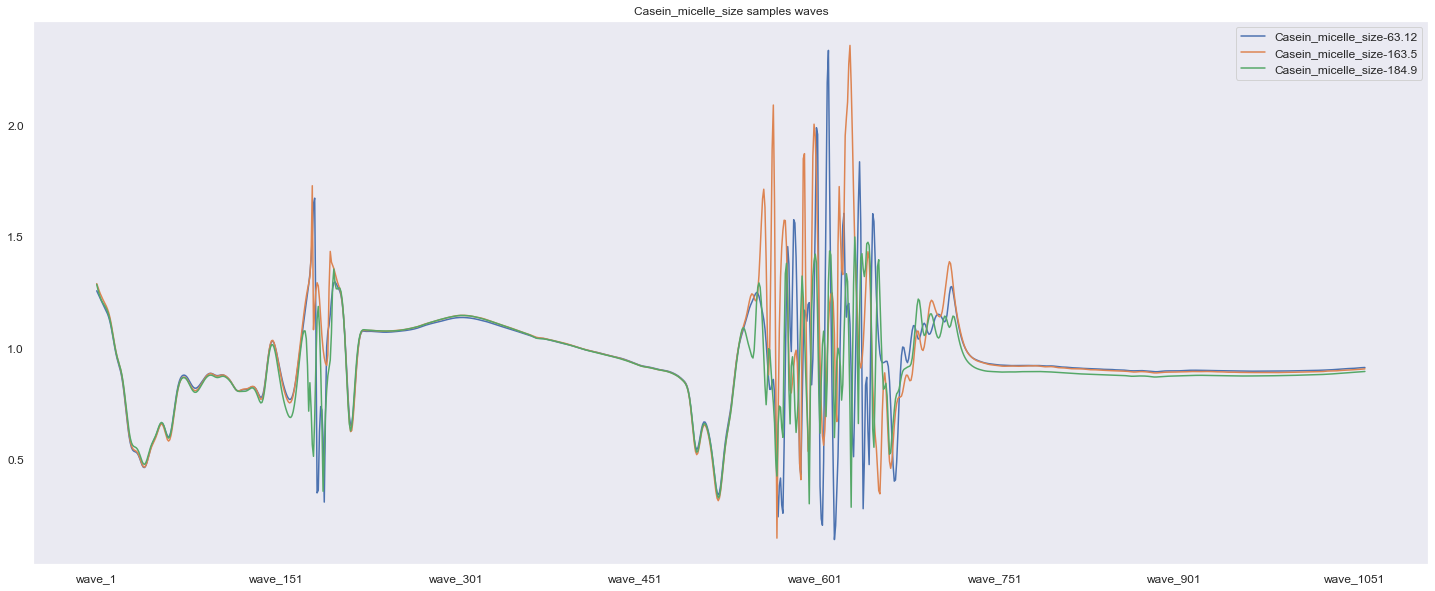

In [56]:
if __name__ == "__main__":
    plotWavesTarget(df = training_casein, features = features, target = 'Casein_micelle_size')

In [57]:
X_casein = training_casein[features]
y_casein = training_casein['Casein_micelle_size']
#print(X_cassein)
print(y_casein.head())

85     142.2
132    139.9
96     177.3
107    245.0
140    158.7
Name: Casein_micelle_size, dtype: float64


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_casein, y_casein, test_size=0.25, random_state=0)

In [59]:
if __name__ == "__main__":
    
    algoCV(target='Casein_micelle_size', X = X_casein, y = y_casein, folds=4)

LinearRegression()
RMSE:  [5.83077313e+05 1.64459847e+08 1.35139784e+08 7.95101393e+06]
R2:  [-5.74796477e+07 -1.73666842e+13 -1.50304850e+13 -1.12317758e+10]
RMSECV:  77033430.43748316
RMSECV std:  73547201.36589612
R2CV:  -8102114619601.23


PLSRegression()
RMSE:  [81.54787247 40.94846102 35.91034437 77.56504895]
R2:  [-0.12431263 -0.07664447 -0.0613184  -0.06889621]
RMSECV:  58.9929317033027
RMSECV std:  20.688509205797445
R2CV:  -0.08279292811677502


Ridge()
RMSE:  [83.2414841  54.81565871 45.23381453 81.71187281]
R2:  [-0.17149772 -0.92932957 -0.68396469 -0.18624317]
RMSECV:  66.25070753775731
RMSECV std:  16.58466349613913
R2CV:  -0.4927587872412027


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
RMSE:  [81.59717669 44.447208   39.787853   77.55932696]
R2:  [-0.12567257 -0.26848728 -0.30288944 -0.06873851]
RMSECV:  60.84789116200342
RMSECV std:  18.85677962870819
R2CV:  -0.19144695028684


RidgeCV(alphas=array([ 0.1,  1. , 10. ]), normalize=True)
RMSE:  [78.10042595 39.38717493 34.7

In [60]:
algos_df = pd.DataFrame({"algo":[], "rmsecv": []})
for i in np.arange(1, 10):
    algo = PLSRegression(n_components=i)
    print(algo)
    scores = cross_validate(algo, X_casein, y_casein, scoring=error_measures, cv=4)
    #scores
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2 = scores['test_r2']
    
    print("RMSE: ", rmse)
    print("R2: ", r2)
    print("RMSECV: ", np.mean(rmse))
    print("RMSECV std: ", np.std(rmse))
    print("R2CV: ", np.mean(r2))
    print("\n")
    algos_df = algos_df.append({"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
       
print(algos_df.sort_values('rmsecv')) 

PLSRegression(n_components=1)
RMSE:  [77.16473203 38.83210597 35.95855628 76.21022459]
R2:  [-0.00669874  0.03176889 -0.06417009 -0.03188163]
RMSECV:  57.0414047170877
RMSECV std:  19.675219291304394
R2CV:  -0.01774539091817995


PLSRegression()
RMSE:  [81.54787247 40.94846102 35.91034437 77.56504895]
R2:  [-0.12431263 -0.07664447 -0.0613184  -0.06889621]
RMSECV:  58.9929317033027
RMSECV std:  20.688509205797445
R2CV:  -0.08279292811677502


PLSRegression(n_components=3)
RMSE:  [78.0187781  40.08784203 36.12325082 77.28418532]
R2:  [-0.02910599 -0.0318641  -0.07394047 -0.06116927]
RMSECV:  57.87851406823512
RMSECV std:  19.824289411194773
R2CV:  -0.04901995612379889


PLSRegression(n_components=4)
RMSE:  [77.88161457 40.66067062 35.40618734 77.14194091]
R2:  [-0.02549066 -0.06156409 -0.0317272  -0.05726662]
RMSECV:  57.77260335829059
RMSECV std:  19.828126340925728
R2CV:  -0.04401214362223044


PLSRegression(n_components=5)
RMSE:  [81.90298969 43.97772909 38.30926462 79.70029172]
R2:  

# Lets look at the best CV models on a single train-test split

In [73]:
lasso = Lasso(normalize=True).fit(X_train, y_train)
# Print the weights learned for each feature.
print("Mean of training targets: \n", y_train.mean())

print("Lasso")
print("\nIntercept: \n", lasso.intercept_)
print("Features and coeficients:", list(zip(features, lasso.coef_))[:10])
#print("Sorted coefs: \n", sorted(lasso.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = lasso.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Casein_micelle_size'))

feature_importance = pd.DataFrame({'feature': features, 'importance':lasso.coef_})
feature_importance.sort_values('importance', ascending=False)

Mean of training targets: 
 182.45842639593909
Lasso

Intercept: 
 182.45842639593909
Features and coeficients: [('wave_1', -0.0), ('wave_2', -0.0), ('wave_3', -0.0), ('wave_4', -0.0), ('wave_5', -0.0), ('wave_6', -0.0), ('wave_7', -0.0), ('wave_8', -0.0), ('wave_9', -0.0), ('wave_10', -0.0)]

RMSE:  64.67673407284599
R2:  -0.00030533740344296234

Actual vs predicted on test:
      Casein_micelle_size   Predicted
188                63.37  182.458426
322               125.00  182.458426
168               126.40  182.458426
120               130.80  182.458426
400               133.70  182.458426
62                134.30  182.458426
334               134.70  182.458426
221               136.00  182.458426
184               139.80  182.458426
132               139.90  182.458426
237               141.60  182.458426
343               143.10  182.458426
127               143.30  182.458426
407               145.40  182.458426
11                145.60  182.458426
128               145.80  18

,feature,importance
0,wave_1,-0.0
712,wave_713,-0.0
698,wave_699,0.0
699,wave_700,-0.0
700,wave_701,-0.0
...,...,...
358,wave_359,-0.0
359,wave_360,-0.0
360,wave_361,-0.0
361,wave_362,-0.0


In [74]:
lasso = Lasso().fit(X_train, y_train)
# Print the weights learned for each feature.
print("Mean of training targets: \n", y_train.mean())

print("Lasso")
print("\nIntercept: \n", lasso.intercept_)
print("Features and coeficients:", list(zip(features, lasso.coef_))[:10])
#print("Sorted coefs: \n", sorted(lasso.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = lasso.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Casein_micelle_size'))

feature_importance = pd.DataFrame({'feature': features, 'importance':lasso.coef_})
feature_importance.sort_values('importance', ascending=False)

Mean of training targets: 
 182.45842639593909
Lasso

Intercept: 
 191.97717806659057
Features and coeficients: [('wave_1', -0.0), ('wave_2', -0.0), ('wave_3', -0.0), ('wave_4', -0.0), ('wave_5', -0.0), ('wave_6', -0.0), ('wave_7', -0.0), ('wave_8', -0.0), ('wave_9', -0.0), ('wave_10', -0.0)]

RMSE:  64.48092263684974
R2:  0.005742423768062888

Actual vs predicted on test:
      Casein_micelle_size   Predicted
188                63.37  191.336087
322               125.00  175.163723
168               126.40  189.673750
120               130.80  167.177557
400               133.70  176.138697
62                134.30  176.978283
334               134.70  173.397967
221               136.00  196.740378
184               139.80  158.852132
132               139.90  178.710962
237               141.60  182.944298
343               143.10  176.904808
127               143.30  191.331618
407               145.40  191.387774
11                145.60  207.014122
128               145.80  190.2

,feature,importance
576,wave_577,15.078486
604,wave_605,6.368195
601,wave_602,4.155863
622,wave_623,3.426106
567,wave_568,2.759115
...,...,...
190,wave_191,-4.320465
180,wave_181,-5.352576
714,wave_715,-5.892195
608,wave_609,-5.997156


In [78]:
svr = SVR(kernel='linear').fit(X_train, y_train)
# Print the weights learned for each feature.
print("Mean of training targets: \n", y_train.mean())

print("SVR(kernel='linear')")
#print("\nIntercept: \n", svr.intercept_)
print("Features and coeficients:", list(zip(features, svr.coef_))[:10])
#print("Sorted coefs: \n", sorted(lasso.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = svr.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Casein_micelle_size'))

feature_importance = pd.DataFrame({'feature': features, 'importance':svr.coef_})
feature_importance.sort_values('importance', ascending=False)

Mean of training targets: 
 182.45842639593909
SVR(kernel='linear')
Features and coeficients: [('wave_1', array([ 0.16759143,  0.17257979,  0.17083529, ..., -0.21154666,
       -0.21761804, -0.22533811]))]

RMSE:  64.68994203829223
R2:  -0.0007139340206436806

Actual vs predicted on test:
      Casein_micelle_size   Predicted
188                63.37  177.310044
322               125.00  168.710099
168               126.40  178.544811
120               130.80  151.789326
400               133.70  175.320778
62                134.30  173.111466
334               134.70  171.495672
221               136.00  174.308790
184               139.80  158.540683
132               139.90  156.005674
237               141.60  166.076484
343               143.10  167.839568
127               143.30  163.383648
407               145.40  177.895518
11                145.60  177.410762
128               145.80  157.901937
244               146.40  173.388116
119               146.50  178.659912
246   

ValueError: Data must be 1-dimensional

In [79]:
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = ridgecv.predict(X_test)
printMetrics(y_test, test_predictions)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Casein_micelle_size'))

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
feature_importance.sort_values('importance', ascending=False)

RidgeCV

Intercept: 
 165.4041252892392
Features and coeficients: [('wave_1', -0.017087298106575603), ('wave_2', -0.01996813862940461), ('wave_3', -0.03681179083733708), ('wave_4', -0.059983304767161565), ('wave_5', -0.08263151277671747), ('wave_6', -0.10069067453663874), ('wave_7', -0.11313847783954949), ('wave_8', -0.12054456982721619), ('wave_9', -0.12251032218697708), ('wave_10', -0.11466541593972496)]

RMSE:  65.17226886985421
R2:  -0.015692168931970008
Actual vs predicted on test:
      Casein_micelle_size   Predicted
188                63.37  182.384094
322               125.00  179.279750
168               126.40  179.695164
120               130.80  176.261060
400               133.70  179.311547
62                134.30  186.838797
334               134.70  188.871364
221               136.00  186.672593
184               139.80  178.315261
132               139.90  176.829115
237               141.60  171.052217
343               143.10  178.469472
127               143.30  

,feature,importance
468,wave_469,4.075444
467,wave_468,4.070816
469,wave_470,4.067032
466,wave_467,4.054669
470,wave_471,4.044498
...,...,...
367,wave_368,-2.334105
369,wave_370,-2.374169
368,wave_369,-2.383237
220,wave_221,-3.208986


In [80]:
# Retrain on full train data and predict for full test set witrh best RidgeCV and GBR
randomforest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = randomforest.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Casein_micelle_size'))

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

RandomForestRegressor

RMSE:  74.1367268515783
R2:  -0.3143264225981963

Actual vs predicted on test:
      Casein_micelle_size  Predicted
188                63.37   198.1340
322               125.00   168.4310
168               126.40   170.5052
120               130.80   168.4660
400               133.70   180.9020
62                134.30   169.1780
334               134.70   178.5990
221               136.00   175.8752
184               139.80   174.2570
132               139.90   169.7672
237               141.60   181.3670
343               143.10   174.1240
127               143.30   179.3840
407               145.40   179.5834
11                145.60   185.3100
128               145.80   181.8690
244               146.40   170.3990
119               146.50   179.4540
246               147.30   202.7012
178               147.50   171.9900
412               148.20   192.7240
414               149.30   194.1280
68                149.40   173.8390
395               149.50   163.01

,feature,importance
692,wave_693,4.395857e-02
667,wave_668,2.915438e-02
711,wave_712,2.625922e-02
694,wave_695,2.395085e-02
198,wave_199,2.230184e-02
...,...,...
869,wave_870,5.431869e-07
1048,wave_1049,3.826834e-07
779,wave_780,3.007231e-07
745,wave_746,2.385735e-07


In [82]:
gbr = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("GradientBoostingRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = gbr.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Casein_micelle_size'))

feature_importance = pd.DataFrame({'feature': features, 'importance':gbr.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

GradientBoostingRegressor

RMSE:  74.31878689135792
R2:  -0.32078961952276397

Actual vs predicted on test:
      Casein_micelle_size   Predicted
188                63.37  197.261359
322               125.00  172.412782
168               126.40  167.712651
120               130.80  125.528676
400               133.70  179.660310
62                134.30  161.779902
334               134.70  175.578108
221               136.00  176.398239
184               139.80  176.025448
132               139.90  172.621052
237               141.60  155.427993
343               143.10  162.023889
127               143.30  174.377486
407               145.40  183.834654
11                145.60  196.195587
128               145.80  189.524959
244               146.40  169.286409
119               146.50  177.609025
246               147.30  167.079000
178               147.50  170.277785
412               148.20  184.409491
414               149.30  195.039816
68                149.40  174.877805
395

,feature,importance
169,wave_170,0.064604
755,wave_756,0.053692
125,wave_126,0.042386
692,wave_693,0.042349
693,wave_694,0.039606
...,...,...
392,wave_393,0.000000
395,wave_396,0.000000
396,wave_397,0.000000
397,wave_398,0.000000


In [83]:
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_casein, y_casein)

# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-Casein_micelle_size-featureimportance-ridgecv-no-outliers-alphas-normalizeTrue.csv', index=False)

# Predicted price on test set
test_predictions = ridgecv.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-Casein_micelle_size']), test_df], axis=1)

test_df_with_predictions.to_csv('23042021-Casein_micelle_size-test-predictions-ridgecv-no-outliers-alphas-normalizeTrue.csv', index=False)

#test_predictions = ridgecv.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

training_predictions = ridgecv.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
print("\nActual vs predicted on training_df:\n", pd.concat([training_df['Casein_micelle_size'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['Casein_micelle_size'].index)], axis=1).sort_values('Casein_micelle_size'))

RidgeCV

Intercept: 
 87.38172537414941
Features and coeficients: [('wave_1', 0.16746957107934657), ('wave_2', 0.18753202149625656), ('wave_3', 0.19655991656465505), ('wave_4', 0.19961213410295187), ('wave_5', 0.20095339469527887), ('wave_6', 0.2026148576883181), ('wave_7', 0.20431035619352808), ('wave_8', 0.20474334284773782), ('wave_9', 0.20374776764627667), ('wave_10', 0.20498679987400417)]
      feature  importance
469  wave_470    3.951605
470  wave_471    3.942524
468  wave_469    3.941881
467  wave_468    3.916147
471  wave_472    3.913763
..        ...         ...
367  wave_368   -1.620023
369  wave_370   -1.649435
368  wave_369   -1.673377
219  wave_220   -1.997389
220  wave_221   -2.261202

[1060 rows x 2 columns]
Predictions on the unlabeled test data: 
 [194.51203097 218.51806233 214.16181909 200.74772094 185.11007372
 182.57026454 199.03109045 190.00469152 182.35934062 177.59577164
 178.34027642 185.55917401 188.77307581 183.11621306 184.40749397
 178.36564598 190.69382288

In [84]:
randomforest = RandomForestRegressor(n_estimators=100).fit(X_casein, y_casein)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
#test_predictions = gbr.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-Casein_micelle_size-featureimportance-randomforest-n100-nooutliers.csv', index=False)

# Predicted price on test set
test_predictions = randomforest.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-kappa_Casein_micelle_size']), test_df], axis=1)
test_df_with_predictions.to_csv('23042021-Casein_micelle_size-test-predictions-randomforest-n100-nooutliers.csv', index=False)

RandomForestRegressor
        feature    importance
708    wave_709  7.198750e-02
693    wave_694  2.576498e-02
707    wave_708  1.992282e-02
667    wave_668  1.728051e-02
713    wave_714  1.703277e-02
...         ...           ...
866    wave_867  1.032814e-06
1032  wave_1033  9.705430e-07
248    wave_249  8.833350e-07
971    wave_972  4.621797e-07
831    wave_832  3.089475e-07

[1060 rows x 2 columns]
Predictions on the unlabeled test data: 
 [232.2597     330.123      273.186      257.4887     187.741
 178.09       208.8494     188.247      179.7855     228.43
 170.803      196.336      175.931      175.369      170.068
 175.655      191.6101     169.559      172.93       179.1022
 167.672      189.653      174.963      164.161      222.6927
 189.46       165.4008     173.9709     176.529      195.4547
 167.3442     387.0261     200.2426     195.251      173.611
 169.114      201.308      168.974      172.962      182.06033333
 213.017      167.992      170.393      199.4485     174

In [89]:
'''
gbr = GradientBoostingRegressor(n_estimators=100).fit(X_casein, y_casein)
# Print the weights learned for each feature.
print("GradientBoostingRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
#test_predictions = gbr.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':gbr.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-Casein_micelle_size-featureimportance-gbr-n100-nooutliers.csv', index=False)

# Predicted price on test set
test_predictions = gbr.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-Casein_micelle_size']), test_df], axis=1)
test_df_with_predictions.to_csv('23042021-Casein_micelle_size-test-predictions-gbr-loss-ls-n100-nooutliers.csv', index=False)

training_predictions = gbr.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
print("\nActual vs predicted on training:\n", pd.concat([training_df['Casein_micelle_size'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['Casein_micelle_size'].index)], axis=1).sort_values('Casein_micelle_size'))
'''

'\ngbr = GradientBoostingRegressor(n_estimators=100).fit(X_casein, y_casein)\n# Print the weights learned for each feature.\nprint("GradientBoostingRegressor")\n#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])\n#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])\n\n# Predicted price on test set\n#test_predictions = gbr.predict(X_test)\n#printMetrics(y_test, test_predictions)\n#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=[\'Predicted\'], index=y_test.index)], axis=1).head())\n\nfeature_importance = pd.DataFrame({\'feature\': features, \'importance\':gbr.feature_importances_})\nprint(feature_importance.sort_values(\'importance\', ascending=False))\nfeature_importance.sort_values(\'importance\', ascending=False).to_csv(\'23042021-Casein_micelle_size-featureimportance-gbr-n100-nooutliers.csv\', index=False)\n\n# Predicted price on test set\ntest_predictions = gbr.predict(test_df)\nprint("P

# Target: ph

In [61]:
training_ph = training_df[training_df["Native_pH"].isnull() == False]
training_ph.describe().T

,count,mean,std,min,25%,50%,75%,max
kappa_casein,394.0,5.899893,1.635110,1.357356,4.863585,5.710210,6.775960,16.733060
Casein_micelle_size,533.0,230.566585,344.646561,63.120000,156.600000,172.500000,193.500000,4063.000000
Native_pH,548.0,6.682051,0.121584,5.860000,6.610000,6.680000,6.754250,7.060000
wave_1,548.0,1.232259,0.055562,1.066316,1.193234,1.227659,1.266478,1.450830
wave_2,548.0,1.220053,0.052582,1.063704,1.184629,1.216305,1.251044,1.430645
...,...,...,...,...,...,...,...,...
wave_1056,548.0,0.916140,0.044300,0.718883,0.903988,0.927823,0.942262,0.993833
wave_1057,548.0,0.916501,0.044300,0.718912,0.904424,0.928037,0.942742,0.994057
wave_1058,548.0,0.916804,0.044303,0.719014,0.904879,0.928097,0.942994,0.994278
wave_1059,548.0,0.917166,0.044305,0.719333,0.905298,0.928456,0.943059,0.994554


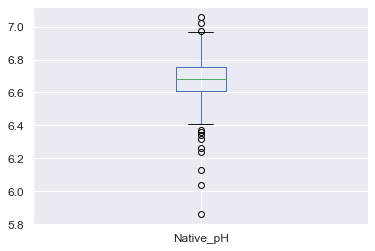

In [62]:
training_ph['Native_pH'].plot(kind='box')

In [63]:
training_ph['Native_pH'].mean() + 3 * training_ph['Native_pH'].std()

7.046801755071595

In [64]:
training_ph = training_ph[training_ph['Native_pH'] <= training_ph['Native_pH'].mean() + 3 * training_ph['Native_pH'].std()]

<ipython-input-46-75ceeb5b85c9>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))


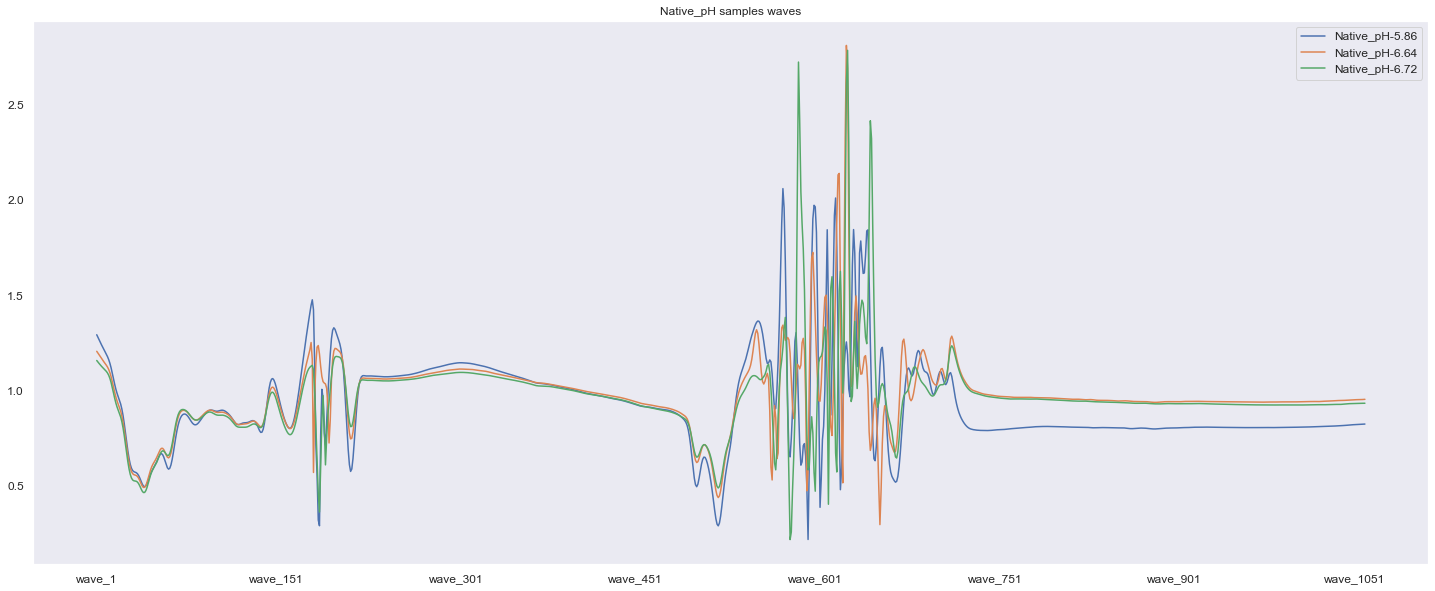

In [65]:
if __name__ == "__main__":
    plotWavesTarget(df = training_ph, features = features, target = 'Native_pH')

In [66]:
X_ph = training_ph[features]
y_ph = training_ph['Native_pH']
#print(X_ph)
#print(y_ph)

print(X_ph.shape)
print(y_ph.shape)

(547, 1060)
(547,)


In [67]:
if __name__ == "__main__":
    
    algoCV(target='Native_pH', X = X_ph, y = y_ph, folds=4)

LinearRegression()
RMSE:  [ 1005.58209467 38651.35988164 10443.07163511 30467.98979022]
R2:  [-8.57131617e+07 -6.81219077e+10 -1.25484078e+10 -5.94636597e+10]
RMSECV:  20142.0008504097
RMSECV std:  15078.910521409414
R2CV:  -35054922103.96912


PLSRegression()
RMSE:  [0.08838316 0.13036338 0.09275931 0.10433604]
R2:  [0.33785748 0.2250593  0.00997287 0.30267904]
RMSECV:  0.10396047040352441
RMSECV std:  0.016320029500893302
R2CV:  0.21889217491965723


Ridge()
RMSE:  [0.09040071 0.11563419 0.0932169  0.09465085]
R2:  [3.07282537e-01 3.90280897e-01 1.80889425e-04 4.26130544e-01]
RMSECV:  0.09847566489317548
RMSECV std:  0.010023769283781571
R2CV:  0.2809687168047114


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
RMSE:  [0.09040071 0.11201212 0.0932169  0.09465085]
R2:  [3.07282537e-01 4.27879800e-01 1.80889425e-04 4.26130544e-01]
RMSECV:  0.09757014641386975
RMSECV std:  0.008477093309372007
R2CV:  0.290368442634051


RidgeCV(alphas=array([ 0.1,  1. , 10. ]), normalize=True)
RMSE:  [0.0694

In [79]:
algos_df = pd.DataFrame({"algo":[], "rmsecv": []})
for i in np.arange(1, 10):
    algo = PLSRegression(n_components=i)
    print(algo)
    scores = cross_validate(algo, X_ph, y_ph, scoring=error_measures, cv=4)
    #scores
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2 = scores['test_r2']
    
    print("RMSE: ", rmse)
    print("R2: ", r2)
    print("RMSECV: ", np.mean(rmse))
    print("RMSECV std: ", np.std(rmse))
    print("R2CV: ", np.mean(r2))
    print("\n")
    algos_df = algos_df.append({"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
       
print(algos_df.sort_values('rmsecv')) 

PLSRegression(n_components=1)
RMSE:  [0.08873722 0.13078957 0.09738941 0.10535009]
R2:  [ 0.33254178  0.21998411 -0.0913287   0.28905852]
RMSECV:  0.10556657152976057
RMSECV std:  0.01570302090483844
R2CV:  0.1875639266139183


PLSRegression()
RMSE:  [0.08838316 0.13036338 0.09275931 0.10433604]
R2:  [0.33785748 0.2250593  0.00997287 0.30267904]
RMSECV:  0.10396047040352441
RMSECV std:  0.016320029500893302
R2CV:  0.21889217491965723


PLSRegression(n_components=3)
RMSE:  [0.09020045 0.12476345 0.09231181 0.10212017]
R2:  [0.31034828 0.29020651 0.01950217 0.33198365]
RMSECV:  0.1023489691660763
RMSECV std:  0.013700297406996612
R2CV:  0.23801015535814546


PLSRegression(n_components=4)
RMSE:  [0.08498657 0.1220172  0.09232725 0.10174857]
R2:  [0.38777219 0.32111013 0.01917405 0.33683638]
RMSECV:  0.10026989831773982
RMSECV std:  0.013890618988690382
R2CV:  0.2662231874010481


PLSRegression(n_components=5)
RMSE:  [0.07650608 0.12285047 0.09262587 0.09581358]
R2:  [0.50385991 0.311806  

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_ph, y_ph, test_size=0.25, random_state=0)

In [76]:
lasso = Lasso(normalize=True).fit(X_train, y_train)
# Print the weights learned for each feature.
print("Mean of training targets: \n", y_train.mean())

print("Lasso")
print("\nIntercept: \n", lasso.intercept_)
print("Features and coeficients:", list(zip(features, lasso.coef_))[:10])
#print("Sorted coefs: \n", sorted(lasso.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = lasso.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':lasso.coef_})
feature_importance.sort_values('importance', ascending=False)

Mean of training targets: 
 6.680370731707318
Lasso

Intercept: 
 6.680370731707318
Features and coeficients: [('wave_1', -0.0), ('wave_2', -0.0), ('wave_3', -0.0), ('wave_4', -0.0), ('wave_5', -0.0), ('wave_6', -0.0), ('wave_7', -0.0), ('wave_8', -0.0), ('wave_9', -0.0), ('wave_10', -0.0)]

RMSE:  0.11796757822596458
R2:  -0.001122669870509574

Actual vs predicted on test:
      Native_pH  Predicted
225      6.670   6.680371
62       6.730   6.680371
213      6.662   6.680371
278      6.550   6.680371
461      6.620   6.680371


,feature,importance
0,wave_1,-0.0
712,wave_713,0.0
698,wave_699,-0.0
699,wave_700,-0.0
700,wave_701,-0.0
...,...,...
358,wave_359,-0.0
359,wave_360,-0.0
360,wave_361,-0.0
361,wave_362,-0.0


In [77]:
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = ridgecv.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Native_pH'))

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
feature_importance.sort_values('importance', ascending=False)

RidgeCV

Intercept: 
 4.174679092275661
Features and coeficients: [('wave_1', 0.2437901837366648), ('wave_2', 0.2017003186224668), ('wave_3', 0.19535698280639155), ('wave_4', 0.22409378088139703), ('wave_5', 0.28192356751052805), ('wave_6', 0.35359166605818865), ('wave_7', 0.4168017996746093), ('wave_8', 0.44570056791401086), ('wave_9', 0.4169029634029506), ('wave_10', 0.3184437846786608)]

RMSE:  0.08689972827258585
R2:  0.4567511631508958

Actual vs predicted on test:
      Native_pH  Predicted
543      6.041   6.638057
318      6.320   6.298805
55       6.360   6.482666
180      6.490   6.618449
156      6.500   6.549990
321      6.531   6.487191
143      6.536   6.574613
265      6.539   6.647351
132      6.540   6.498241
125      6.545   6.689326
238      6.547   6.539217
278      6.550   6.707508
251      6.550   6.434054
371      6.554   6.503367
208      6.560   6.639786
9        6.567   6.537475
16       6.580   6.604378
367      6.580   6.591951
222      6.580   6.543953
131 

,feature,importance
425,wave_426,3.546430
424,wave_425,3.511128
426,wave_427,3.302234
423,wave_424,3.234391
422,wave_423,2.779270
...,...,...
435,wave_436,-1.943483
433,wave_434,-1.972510
434,wave_435,-2.121008
219,wave_220,-2.639107


In [78]:
# Retrain on full train data and predict for full test set witrh best RidgeCV and GBR
randomforest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = randomforest.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).sort_values('Native_pH'))

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

RandomForestRegressor

RMSE:  0.1006358659571576
R2:  0.27143627472275345

Actual vs predicted on test:
      Native_pH  Predicted
543      6.041   6.670650
318      6.320   6.288920
55       6.360   6.611220
180      6.490   6.619949
156      6.500   6.675120
321      6.531   6.603725
143      6.536   6.616677
265      6.539   6.626822
132      6.540   6.644250
125      6.545   6.730900
238      6.547   6.630120
278      6.550   6.670690
251      6.550   6.554960
371      6.554   6.627835
208      6.560   6.558745
9        6.567   6.539210
16       6.580   6.671580
367      6.580   6.643935
222      6.580   6.608777
131      6.590   6.651340
337      6.596   6.623553
324      6.599   6.662907
492      6.600   6.630237
421      6.600   6.660530
195      6.600   6.604360
59       6.600   6.632770
368      6.601   6.665055
399      6.610   6.665431
356      6.610   6.655510
170      6.610   6.765900
286      6.613   6.606635
40       6.620   6.706590
552      6.620   6.867810
541      6.

,feature,importance
572,wave_573,4.174850e-02
72,wave_73,3.042815e-02
70,wave_71,2.867012e-02
529,wave_530,2.238548e-02
641,wave_642,2.221605e-02
...,...,...
806,wave_807,1.219647e-06
1020,wave_1021,1.170455e-06
1041,wave_1042,1.103086e-06
923,wave_924,7.849170e-07


In [101]:
'''
gbr = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
# Print the weights learned for each feature.
print("GradientBoostingRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
test_predictions = gbr.predict(X_test)
printMetrics(y_test, test_predictions)
print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head(100))

feature_importance = pd.DataFrame({'feature': features, 'importance':gbr.feature_importances_})
feature_importance.sort_values('importance', ascending=False)
'''

'\ngbr = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)\n# Print the weights learned for each feature.\nprint("GradientBoostingRegressor")\n#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])\n#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])\n\n# Predicted price on test set\ntest_predictions = gbr.predict(X_test)\nprintMetrics(y_test, test_predictions)\nprint("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=[\'Predicted\'], index=y_test.index)], axis=1).head(100))\n\nfeature_importance = pd.DataFrame({\'feature\': features, \'importance\':gbr.feature_importances_})\nfeature_importance.sort_values(\'importance\', ascending=False)\n'

In [102]:
ridgecv = RidgeCV(alphas=np.logspace(-2, 2, 10), normalize=True).fit(X_ph, y_ph)

# Print the weights learned for each feature.
print("RidgeCV")
print("\nIntercept: \n", ridgecv.intercept_)
print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted features and coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

feature_importance = pd.DataFrame({'feature': features, 'importance':ridgecv.coef_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-Native_pH-featureimportance-ridgecv-no-outliers-alphas-normalizeTrue.csv', index=False)

# Predicted price on test set
test_predictions = ridgecv.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-Native_pH']), test_df], axis=1)
test_df_with_predictions.to_csv('23042021-Native_pH-test-predictions-ridgecv-no-outliers-alphas-normalizeTrue.csv', index=False)

#test_predictions = ridgecv.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

training_predictions = ridgecv.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
print("\nActual vs predicted on training_df:\n", pd.concat([training_df['Native_pH'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['Native_pH'].index)], axis=1).head(600).sort_values('Native_pH'))

RidgeCV

Intercept: 
 5.101778438063048
Features and coeficients: [('wave_1', 0.5224254791275788), ('wave_2', 0.4107030898304167), ('wave_3', 0.303126281122272), ('wave_4', 0.2350668672685827), ('wave_5', 0.23386300263261592), ('wave_6', 0.29836097532120953), ('wave_7', 0.3983101284071355), ('wave_8', 0.4838916904599191), ('wave_9', 0.5025805779152667), ('wave_10', 0.4208965377067931)]
      feature  importance
424  wave_425    3.240414
425  wave_426    3.199241
423  wave_424    3.045543
426  wave_427    2.904728
422  wave_423    2.657097
..        ...         ...
392  wave_393   -1.993500
391  wave_392   -1.997597
433  wave_434   -2.115596
434  wave_435   -2.208602
219  wave_220   -2.451449

[1060 rows x 2 columns]
Predictions on the unlabeled test data: 
 [6.35003554 6.94132245 6.94938754 6.93794405 6.56960405 6.71093159
 6.44563284 6.64778508 6.47986134 6.72216594 6.66154255 6.67669431
 6.78659683 6.72960314 6.61801307 6.7317373  6.66073282 6.63314823
 6.72130231 6.35514295 6.793785

In [103]:
randomforest = RandomForestRegressor(n_estimators=100).fit(X_ph, y_ph)
# Print the weights learned for each feature.
print("RandomForestRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
#test_predictions = gbr.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':randomforest.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))
feature_importance.sort_values('importance', ascending=False).to_csv('23042021-Native_pH-featureimportance-randomforest-n100-noutliers.csv', index=False)

# Predicted price on test set
test_predictions = randomforest.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-Native_pH']), test_df], axis=1)
test_df_with_predictions.to_csv('23042021-Native_pH-test-predictions-n100-randomforest-nooutliers.csv', index=False)

training_predictions = randomforest.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
print("\nActual vs predicted on training:\n", pd.concat([training_df['Native_pH'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['Native_pH'].index)], axis=1).head(600))

RandomForestRegressor
      feature  importance
139  wave_140    0.074290
205  wave_206    0.039883
572  wave_573    0.039288
550  wave_551    0.020954
138  wave_139    0.020066
..        ...         ...
807  wave_808    0.000002
914  wave_915    0.000002
236  wave_237    0.000002
992  wave_993    0.000002
272  wave_273    0.000001

[1060 rows x 2 columns]
Predictions on the unlabeled test data: 
 [6.5204     6.8183     6.84432    6.82235    6.70461667 6.70214
 6.39414    6.64959    6.66135    6.65866    6.70639    6.6881
 6.80483    6.69099    6.63304    6.69273    6.68341    6.64504
 6.77637    6.624825   6.7445     6.53647333 6.73249    6.60499667
 6.54153    6.63324    6.78252    6.76697    6.67679    6.622435
 6.76338    6.71577    6.66789    6.75416    6.7048125  6.635555
 6.71324    6.67852667 6.67097    6.65022    6.58331    6.63673
 6.636545   6.71514    6.64861    6.62238667 6.611375   6.66861833
 6.65197    6.6848     6.65653    6.62449    6.66518    6.624735
 6.62524333 6.6

In [ ]:
'''
gbr = GradientBoostingRegressor(n_estimators=100).fit(X_ph, y_ph)
# Print the weights learned for each feature.
print("GradientBoostingRegressor")
#print("Features and coeficients:", list(zip(features, ridgecv.coef_))[:10])
#print("Sorted coefs: \n", sorted(ridgecv.coef_, reverse=False)[:10])

# Predicted price on test set
#test_predictions = gbr.predict(X_test)
#printMetrics(y_test, test_predictions)
#print("\nActual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head())

feature_importance = pd.DataFrame({'feature': features, 'importance':gbr.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))

# Predicted price on test set
test_predictions = gbr.predict(test_df)
print("Predictions on the unlabeled test data: \n", test_predictions)
test_df_with_predictions = pd.concat([pd.DataFrame(test_predictions, columns=['predicted-Native_pH']), test_df], axis=1)

test_df_with_predictions.to_csv('16042021-Native_pH-test-predictions-gbr-loss-ls-n100-nooutliers.csv', index=False)

training_predictions = gbr.predict(training_df[features] )
#printMetrics(training_df['kappa_casein'], training_predictions)
print("Actual vs predicted on test:\n", pd.concat([training_df['Native_pH'], pd.DataFrame(training_predictions, columns=['Predicted'], index=training_df['Native_pH'].index)], axis=1).head(600))
'''

# References: 
+ https://www.journalofdairyscience.org/action/showPdf?pii=S0022-0302%2821%2900509-9
+ https://scikit-learn.org/stable/supervised_learning.html
+ https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
+ https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5
+ https://www.tandfonline.com/doi/full/10.1080/09540100400013401
+ https://www.sigmaaldrich.com/life-science/metabolomics/enzyme-explorer/enzyme-reagents/casein.html
+ http://archive.dimacs.rutgers.edu/Research/MMS/loglasso-v3a.pdf